
SumSquares: 2D


In [1]:
pip install pyGPGO


  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=1cf039848791a3327bb5ae4c0566ab047a0eaf09f806177afafe1572f1c9811f
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
Successfully built pyGPGO


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'SumSquares'
n_test = 500
eps = 1e-08

util = 'EI'

n_init = 5 # random initialisations
iters = 20
opt = True

In [4]:
### Objective Function - Sum Squares(x) 2-D:

def objfunc(x1_training, x2_training):
            return  operator * (  1 * x1_training ** 2
                            + 2 * x2_training ** 2
                            )
        
# Constraints:
lb = -5.12
ub = +5.12
    
# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
                 'x2_training': ('cont', [lb, ub])
                 }
    
# True y bounds:
y_lb = 0
operator = -1 # targets global minimum 
y_global_orig = y_lb * operator # targets global minimum
    
# Test data:
x1_test = np.linspace(lb, ub, n_test)
x2_test = np.linspace(lb, ub, n_test)
x_test = np.column_stack((x1_test, x2_test))


In [5]:
n_start_AcqFunc = iters


In [6]:
### Cumulative Regret Calculators:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  
def acqFuncExact(x):
    new_array = []
    x = np.array(x) * -1
    for i, num in enumerate(x):
            new_array = x[:-2][::-3]
    return new_array[::-1]

def acqFuncApprox(x):
    new_array = []
    x = np.array(x) * -1
    for i, num in enumerate(x):
            new_array = x[:-1][::-3]
    return new_array[::-1]


In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           


In [8]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'EI': self.EI
        }

        self.f = mode_dict[mode]
    
    def EI(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
## GPGO_multi: 

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max. ExactAcqFunc \t Max. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

        x_best_exact = np.empty((n_start, len(self.parameter_key)))
        f_best_exact = np.empty((n_start,))
        opt_exact = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_exact = np.array([res.x for res in opt_exact])
        f_best_exact = np.array([np.atleast_1d(res.fun)[0] for res in opt_exact])
        f_best_min_exact = min(f_best_exact)

        self.x_best_exact = x_best_exact
        self.f_best_exact = f_best_exact
        self.f_best_min_exact = f_best_min_exact
        self.best_exact = x_best_exact[np.argmin(f_best_exact)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min_exact)

    def _printInit(self):
        print(self.header)
        inverse = -1
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        inverse = -1
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        max_acqfunc = str(inverse * self.f_best_min)
        max_acqfunc_exact = str(inverse * self.f_best_min_exact)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + max_acqfunc + ENDC
            max_acqfunc_exact = BOLD + OKGREEN + max_acqfunc_exact + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc_exact, max_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## dGPGO:

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max. ExactAcqFunc \t Max. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min)

        x_best_approx = np.empty((n_start, len(self.parameter_key)))
        f_best_approx = np.empty((n_start,))
        opt_approx = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_approx = np.array([res.x for res in opt_approx])
        f_best_approx = np.array([np.atleast_1d(res.fun)[0] for res in opt_approx])
        f_best_min_approx = min(f_best_approx)

        self.x_best_approx = x_best_approx
        self.f_best_approx = f_best_approx
        self.f_best_min_approx = f_best_min_approx
        self.best_approx = x_best_approx[np.argmin(f_best_approx)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min_approx)
    
    def _printInit(self):
        print(self.header)
        inverse = -1
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        inverse = -1
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        max_acqfunc = str(inverse * self.f_best_min)
        max_acqfunc_approx = str(inverse * self.f_best_min_approx)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + max_acqfunc + ENDC
            max_acqfunc_approx = BOLD + OKGREEN + max_acqfunc_approx + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc, max_acqfunc_approx))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_approx = time.time()
start_approx


1653144282.4212773

In [13]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=opt)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition_grad(util), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-0.84969467  2.25612281]	 10.902161328666502	 1.4334486961549602	    	    
init	 [-5.1188288  -2.02411446]	 34.396486966857985	 1.4334486961549602	    	    
init	 [-3.61721968 -4.17445279]	 47.936390383803385	 1.4334486961549602	    	    
init	 [-3.21269544 -1.58145816]	 15.323431753768267	 1.4334486961549602	    	    
init	 [-1.05710106  0.39748336]	 1.4334486961549602	 1.4334486961549602	    	    
1  	 [ 4.04077223 -4.24914728]	 52.43834538835027	 1.4334486961549602	 1.7112010740719603	 1.7112010740719603
2  	 [5.12 5.12]	 78.64320000000001	 1.4334486961549602	 1.7112004087720267	 1.7112010728292422
3  	 [-5.12  5.12]	 78.64320000000001	 1.4334486961549602	 1.710574129960556	 1.7111935407834726
4  	 [3.43986628 0.50783871]	 12.348480294532642	 1.4334486961549602	 1.7107109165970313	 1.7107244263458163
5  	 [ 0.4730055  -2.24615185]	 10.314130466460801	 1.433448696154960

In [14]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=opt)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition_grad(util), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-0.6554122  -4.85451539]	 47.562204422038214	 1.1358959044973735	    	    
init	 [ 0.50854377 -0.6622987 ]	 1.1358959044973735	 1.1358959044973735	    	    
init	 [-0.81543371 -1.73737143]	 6.7018511217540135	 1.1358959044973735	    	    
init	 [-3.02439799  1.2213347 ]	 12.13030006303276	 1.1358959044973735	    	    
init	 [-2.05153614 -2.3876887 ]	 15.610915224537823	 1.1358959044973735	    	    
1  	 [4.81874241 3.07464552]	 42.12716849729408	 1.1358959044973735	 1.4911666224516105	 1.4911666029104134
2  	 [ 5.00548033 -2.94592692]	 42.41180414329284	 1.1358959044973735	 1.4911634137675465	 1.4911654113999986
3  	 [-0.023795  5.12    ]	 52.429366202083486	 1.1358959044973735	 1.4911274672835144	 1.4911275198820604
4  	 [-5.12  5.12]	 78.64320000000001	 1.1358959044973735	 1.4892808751121378	 1.4908823114998508
5  	 [-5.12 -5.12]	 78.64320000000001	 1.1358959044973735	 

In [15]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=opt)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition_grad(util), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.52017052 2.1314337 ]	 9.356596638100186	 4.609047504113831	    	    
init	 [-2.14113547  0.11087468]	 4.609047504113831	 4.609047504113831	    	    
init	 [4.02377681 4.05804123]	 49.12617709674532	 4.609047504113831	    	    
init	 [-3.83400642 -2.99783293]	 32.673609761904345	 4.609047504113831	    	    
init	 [-4.59297584 -0.6061072 ]	 21.83015892853491	 4.609047504113831	    	    
1  	 [ 4.70125543 -1.78661127]	 28.48576230514968	 4.609047504113831	 4.616263286354368	 4.616273133946969
2  	 [-4.57940679  5.0984075 ]	 72.95848473795671	 4.609047504113831	 4.616230926594989	 4.616272775878096
3  	 [ 0.85872279 -5.12      ]	 53.16620483185148	 4.609047504113831	 4.616169141236741	 4.616212604312295
4  	 [-0.49057758  5.12      ]	 52.66946636605207	 4.609047504113831	 4.5719405154982535	 4.575440806094532
5	 [ 0.88210751 -1.24207135]	 3.8635961330595094	 3.8635961330595

In [16]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=opt)

approx_4= GPGO_multi(surrogate_approx_4, Acquisition_grad(util), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [4.78238555 0.48365823]	 23.33906213310676	 7.289910254474112	    	    
init	 [4.84028785 2.19971578]	 33.10588541607836	 7.289910254474112	    	    
init	 [ 2.02474316 -2.90724357]	 21.003715175118646	 7.289910254474112	    	    
init	 [ 4.87705042 -5.05620219]	 74.91598187475032	 7.289910254474112	    	    
init	 [-2.52946061 -0.66773471]	 7.289910254474112	 7.289910254474112	    	    
1  	 [-0.25124201  4.86510597]	 47.40163474011513	 7.289910254474112	 7.289974290139221	 7.28997423228526
2  	 [-5.12 -5.12]	 78.64320000000001	 7.289910254474112	 7.289969024590992	 7.289969024590992
3  	 [-5.12        3.49072983]	 50.58478954560735	 7.289910254474112	 7.273999495310039	 7.2898873531218475
4  	 [-0.97408008 -5.12      ]	 53.377632002437004	 7.289910254474112	 7.26828486413313	 7.272551093967492
5	 [0.75195295 0.88075035]	 2.1168755879990946	 2.1168755879990946	 7.25790446

In [17]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=opt)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition_grad(util), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.84678993  3.79629882]	 36.927982283829365	 2.6327313115208373	    	    
init	 [-3.00319585  4.2865757 ]	 45.76864772649561	 2.6327313115208373	    	    
init	 [-0.11866943  1.14425716]	 2.6327313115208373	 2.6327313115208373	    	    
init	 [2.72289645 0.1886002 ]	 7.485305147100433	 2.6327313115208373	    	    
init	 [-2.08076286 -3.19773462]	 24.780587476435763	 2.6327313115208373	    	    
1  	 [ 4.32895605 -5.09732646]	 70.70533460957368	 2.6327313115208373	 2.720663595320647	 2.720663595320647
2  	 [5.12 5.12]	 78.64320000000001	 2.6327313115208373	 2.7206633928755997	 2.7206633928755997
3  	 [-5.12      -0.0409628]	 26.21775590193081	 2.6327313115208373	 2.7188033976935158	 2.719298092500379
4  	 [0.97506508 5.12      ]	 53.37955191960947	 2.6327313115208373	 2.7067471286667972	 2.7068686887406455
5  	 [-5.12 -5.12]	 78.64320000000001	 2.6327313115208373	 2.70319

In [18]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=opt)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition_grad(util), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 4.02288795 -1.72052679]	 22.104052359713652	 1.4757178799086357	    	    
init	 [ 3.28938622 -4.69302655]	 54.869058151382724	 1.4757178799086357	    	    
init	 [-4.0175956   0.97333314]	 18.035829177697114	 1.4757178799086357	    	    
init	 [ 0.30532979 -0.83141193]	 1.4757178799086357	 1.4757178799086357	    	    
init	 [-1.68542362  1.25459899]	 5.988690020231891	 1.4757178799086357	    	    
1  	 [4.75547487 4.58960031]	 64.74340336580451	 1.4757178799086357	 1.7435985764508002	 1.7435992135603884
2  	 [-5.12 -5.12]	 78.64320000000001	 1.4757178799086357	 1.743598461232859	 1.7435991956341772
3  	 [-0.16997956  5.12      ]	 52.45769305082403	 1.4757178799086357	 1.7431054523295966	 1.7431054516677857
4  	 [-5.12  5.12]	 78.64320000000001	 1.4757178799086357	 1.7368583835941291	 1.7428084334047338
5  	 [-0.93403445 -4.07437714]	 34.07351843941727	 1.4757178799086357

In [19]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=opt)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition_grad(util), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-4.33860312  2.86636843]	 35.25561298730891	 5.622520458601941	    	    
init	 [-0.63068947  2.28828342]	 10.870251237170722	 5.622520458601941	    	    
init	 [4.8946126  0.39419771]	 24.268016205804518	 5.622520458601941	    	    
init	 [ 0.01147355 -4.38219639]	 38.407422120416236	 5.622520458601941	    	    
init	 [-2.37118484e+00 -1.20319155e-03]	 5.622520458601941	 5.622520458601941	    	    
1  	 [-5.12 -5.12]	 78.64320000000001	 5.622520458601941	 5.623958007331099	 5.623958007331099
2  	 [ 5.12 -5.12]	 78.64320000000001	 5.622520458601941	 5.623902201337749	 5.623951706467235
3  	 [3.47384427 5.12      ]	 64.49639400778015	 5.622520458601941	 5.62390220687059	 5.623902209010503
4  	 [-4.02558214 -1.33646422]	 19.777584798449002	 5.622520458601941	 5.6239860724777975	 5.6239860724777975
5	 [ 1.31197601 -0.73516326]	 2.8022110834805054	 2.8022110834805054	 5.592230

In [20]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=opt)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition_grad(util), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [3.82391708 4.79785639]	 60.661193695854244	 0.1518306274298758	    	    
init	 [3.78055209 0.31596228]	 14.492238445440277	 0.1518306274298758	    	    
init	 [-2.73686192 -5.00327624]	 57.555959528959804	 0.1518306274298758	    	    
init	 [-0.7119993  -0.99992207]	 2.506631309190485	 0.1518306274298758	    	    
init	 [ 0.23218863 -0.22126801]	 0.1518306274298758	 0.1518306274298758	    	    
1  	 [0.19003629 1.84102391]	 6.814851889572508	 0.1518306274298758	 0.8790463809219381	 0.8794403154231772
2  	 [-5.03492225  2.95509263]	 42.81558690689544	 0.1518306274298758	 0.876097928789002	 0.876097928789002
3  	 [-5.12       -1.28527369]	 29.518256918464733	 0.1518306274298758	 0.8760964873295525	 0.8760978923461425
4  	 [ 5.12 -5.12]	 78.64320000000001	 0.1518306274298758	 0.8760781327570487	 0.8760973285851136
5  	 [-1.33960731  5.12      ]	 54.22334773354572	 0.15183062

In [21]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=opt)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition_grad(util), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-5.01376866  0.01919582]	 25.138613177506063	 14.00341364504739	    	    
init	 [-0.04328148 -3.74958562]	 28.12065798163534	 14.00341364504739	    	    
init	 [-3.66478248 -2.88195916]	 30.04200788009657	 14.00341364504739	    	    
init	 [-0.83447623 -2.57944404]	 14.00341364504739	 14.00341364504739	    	    
init	 [-4.25922917 -1.58209393]	 23.14707552082245	 14.00341364504739	    	    
1  	 [3.69491889 4.82146316]	 60.145439711826235	 14.00341364504739	 14.003413635047737	 14.003413635047737
2  	 [-2.39452106  5.12      ]	 58.16253112090631	 14.00341364504739	 14.003409908105493	 14.0034125309468
3  	 [ 5.12       -0.84962704]	 27.658132201923962	 14.00341364504739	 14.003412555437176	 14.003412163177655
4  	 [ 4.4995362 -5.12     ]	 72.67462602766071	 14.00341364504739	 14.001726157354163	 14.001991596407745
5	 [0.57075089 1.35359272]	 3.9901830840235584	 3.99018308

In [22]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=opt)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition_grad(util), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.77832339 -4.90750004]	 55.886194099964676	 14.855028828430257	    	    
init	 [1.36855793 2.54775176]	 14.855028828430257	 14.855028828430257	    	    
init	 [-0.01528819 -2.81808235]	 15.883409988980564	 14.855028828430257	    	    
init	 [-3.09183626  2.66783449]	 23.79413325191142	 14.855028828430257	    	    
init	 [-3.38830503 -4.2154003 ]	 47.019810427389544	 14.855028828430257	    	    
1  	 [ 5.12       -0.36616676]	 26.482556193639997	 14.855028828430257	 14.854874684222002	 14.854874683981976
2  	 [5.12 5.12]	 78.64320000000001	 14.855028828430257	 14.854786129003225	 14.854786129003225
3  	 [-5.12       -0.57725913]	 26.88085620573987	 14.855028828430257	 14.797141080031341	 14.840154352328407
4  	 [-0.6447398  5.12     ]	 52.84448941421828	 14.855028828430257	 14.715873558345969	 14.789770365812247
5  	 [-5.12  5.12]	 78.64320000000001	 14.855028828430257	 

In [23]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=opt)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition_grad(util), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-3.27403839 -4.92057353]	 59.14341502486697	 0.7122141741228657	    	    
init	 [-0.37664229  2.30332343]	 10.752457105378047	 0.7122141741228657	    	    
init	 [-0.81711509 -0.14922651]	 0.7122141741228657	 0.7122141741228657	    	    
init	 [-4.98912446 -0.12931474]	 24.924807467825406	 0.7122141741228657	    	    
init	 [4.52410012 3.59214172]	 46.27444610017016	 0.7122141741228657	    	    
1  	 [ 5.12       -3.40237282]	 49.36668165605576	 0.7122141741228657	 1.2040544468937107	 1.2040544932414967
2  	 [-5.00035648  5.12      ]	 77.4323648830559	 0.7122141741228657	 1.2012154115887672	 1.204044740928416
3  	 [ 1.12961109 -5.12      ]	 53.704821221313104	 0.7122141741228657	 1.2016575532638238	 1.2016578244269196
4  	 [ 2.385487   -0.29971634]	 5.870207990016677	 0.7122141741228657	 1.195988586135117	 1.1967393157745028
5  	 [1.01599187 5.12      ]	 53.46103947165767

In [24]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=opt)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition_grad(util), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-3.54137249  2.45810889]	 24.62591779447066	 6.112828495563743	    	    
init	 [-2.42365424  0.34549139]	 6.112828495563743	 6.112828495563743	    	    
init	 [-4.97075238  4.28796936]	 61.48174177959852	 6.112828495563743	    	    
init	 [ 4.10332011 -4.77776458]	 62.49130467854858	 6.112828495563743	    	    
init	 [ 4.6791612  -3.71497655]	 49.4966510918416	 6.112828495563743	    	    
1  	 [5.12       3.50749904]	 50.819498996932666	 6.112828495563743	 6.113453825422314	 6.113453825344287
2  	 [-3.57825579 -5.12      ]	 65.23271449574408	 6.112828495563743	 6.113453801922175	 6.113453368019438
3  	 [0.42914409 5.12      ]	 52.612964648028544	 6.112828495563743	 6.113205690762846	 6.113205803362474
4	 [1.79051921 0.02638833]	 3.2073517365805846	 3.2073517365805846	 6.1122076967065295	 6.112560701609489
5  	 [ 0.10947088 -3.03156958]	 18.392812147400484	 3.2073517365805

In [25]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=opt)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition_grad(util), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.84367268 -2.68757791]	 22.532624345992815	 12.440151302029248	    	    
init	 [3.32061217 4.76927179]	 56.51837198799	 12.440151302029248	    	    
init	 [ 4.83943541 -0.47667971]	 23.87458213765974	 12.440151302029248	    	    
init	 [1.11659482 2.82139151]	 17.16728408945556	 12.440151302029248	    	    
init	 [1.45012065 2.27346667]	 12.440151302029248	 12.440151302029248	    	    
1  	 [-4.9716482  -2.70396399]	 39.340128339980055	 12.440151302029248	 12.440151292105428	 12.440151292104815
2  	 [-4.13632762  5.12      ]	 69.53800618572845	 12.440151302029248	 12.440117925819965	 12.440150768483434
3  	 [-0.98138883 -5.12      ]	 53.39192404225702	 12.440151302029248	 12.439377373905945	 12.439394253334793
4	 [-2.51910418  0.81499634]	 7.67432392093602	 7.67432392093602	 12.434102075908234	 12.435574487174593
5  	 [ 5.12 -5.12]	 78.64320000000001	 7.67432392093602	 

In [26]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=opt)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition_grad(util), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.14277984 2.79721013]	 15.669155142359655	 6.942951853664133	    	    
init	 [ 3.7931795  -5.03759925]	 65.14302308089468	 6.942951853664133	    	    
init	 [-1.94830412  4.68586229]	 47.71049977745547	 6.942951853664133	    	    
init	 [ 0.13431513 -1.86076749]	 6.942951853664133	 6.942951853664133	    	    
init	 [ 0.40140736 -2.85434939]	 16.455748743182696	 6.942951853664133	    	    
1  	 [-4.76090432 -5.12      ]	 75.09500996907528	 6.942951853664133	 6.943082659813248	 6.94308178638531
2  	 [5.12 5.12]	 78.64320000000001	 6.942951853664133	 6.943080670728825	 6.943080670728825
3  	 [-5.12       0.3583155]	 26.47117999972528	 6.942951853664133	 6.943057655947545	 6.943058285365614
4  	 [ 5.12       -0.06635627]	 26.223206308423958	 6.942951853664133	 6.942929141681541	 6.942964214529009
5	 [-1.74037537  0.04509973]	 3.032974397606459	 3.032974397606459	 6.827427109

In [27]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=opt)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_grad(util), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 3.57189322 -3.28810573]	 34.38169974295086	 5.478261179905657	    	    
init	 [-4.56332069 -1.41784631]	 24.84447200795673	 5.478261179905657	    	    
init	 [-2.29989449  0.3072023 ]	 5.478261179905657	 5.478261179905657	    	    
init	 [-1.9873903  -2.00218256]	 11.967190241167383	 5.478261179905657	    	    
init	 [-3.97576933 -2.5610341 ]	 28.924533081850157	 5.478261179905657	    	    
1  	 [1.24561953 5.12      ]	 53.980368025433464	 5.478261179905657	 5.4801254589254675	 5.4801254161906146
2  	 [-4.70989644  5.12      ]	 74.61192451925021	 5.478261179905657	 5.4800689612695095	 5.480123662543259
3  	 [5.12       1.65417582]	 31.686995264854865	 5.478261179905657	 5.4760672518225375	 5.480063315610684
4  	 [-0.1080015 -5.12     ]	 52.44046432362896	 5.478261179905657	 5.461911087231399	 5.469540330994413
5	 [1.2565831  0.45859706]	 1.9996236166339594	 1.99962361663

In [28]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=opt)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition_grad(util), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.83349935  0.23719262]	 8.141239237549925	 8.141239237549925	    	    
init	 [ 0.51918292 -4.65303603]	 43.571039504503474	 8.141239237549925	    	    
init	 [-1.42613673 -2.83565116]	 18.11570093066862	 8.141239237549925	    	    
init	 [ 1.9325559  -3.44339021]	 27.448644544199137	 8.141239237549925	    	    
init	 [-4.39987336  4.51595121]	 60.146516261103784	 8.141239237549925	    	    
1  	 [4.54178969 5.12      ]	 73.05665355886045	 8.141239237549925	 8.14124965339457	 8.14124965339457
2  	 [5.12       0.09204135]	 26.231343221707153	 8.141239237549925	 8.141006678398663	 8.141006764346118
3  	 [-5.12 -5.12]	 78.64320000000001	 8.141239237549925	 8.14054690762893	 8.14054690762893
4  	 [0.28405291 3.1214406 ]	 19.567468894816013	 8.141239237549925	 8.13998680222149	 8.139987791035066
5  	 [ 5.12 -5.12]	 78.64320000000001	 8.141239237549925	 8.036260344383606	 8.12

In [29]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=opt)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition_grad(util), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.10263037  0.31320838]	 4.617253458637031	 3.1817562258207746	    	    
init	 [-3.15882714 -4.42470033]	 49.134134969019556	 3.1817562258207746	    	    
init	 [2.93873111 1.60085526]	 13.761615685279608	 3.1817562258207746	    	    
init	 [1.40821398 0.77417363]	 3.1817562258207746	 3.1817562258207746	    	    
init	 [-4.71999574 -1.45598869]	 26.518165900202685	 3.1817562258207746	    	    
1  	 [ 4.96008736 -4.44720822]	 64.15778856025273	 3.1817562258207746	 3.2292491629897406	 3.2292491629897406
2  	 [-4.56384581  4.97019236]	 70.23431270211115	 3.1817562258207746	 3.2292310374713087	 3.2292471428544713
3  	 [0.30859807 5.12      ]	 52.52403276951771	 3.1817562258207746	 3.2280346428673106	 3.2285718409990274
4  	 [5.12 5.12]	 78.64320000000001	 3.1817562258207746	 3.2278017224203137	 3.2278017224203137
5  	 [ 0.86766221 -2.75614833]	 15.945544952761132	 3.18175622

In [30]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=opt)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition_grad(util), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [1.53983224 0.05584255]	 2.3773200933391867	 2.3773200933391867	    	    
init	 [ 3.87687906 -3.25795609]	 36.25874706055664	 2.3773200933391867	    	    
init	 [3.60686662 2.56139557]	 26.130981366974602	 2.3773200933391867	    	    
init	 [1.70088108 4.99604939]	 52.81401545301259	 2.3773200933391867	    	    
init	 [-2.48864335 -4.83014733]	 52.85399210258478	 2.3773200933391867	    	    
1  	 [-5.00718904  2.9174042 ]	 42.09443666312248	 2.3773200933391867	 2.49215984197688	 2.49215984197688
2  	 [-2.12502026 -0.37419957]	 4.795761729550591	 2.3773200933391867	 2.4886746548349485	 2.4886747906910247
3  	 [-5.12     -1.669142]	 31.78647000785484	 2.3773200933391867	 2.4353315310783517	 2.4764125632251504
4  	 [-2.08580923  5.12      ]	 56.77940016280741	 2.3773200933391867	 2.445686793248634	 2.451467322085882
5  	 [ 0.32981063 -2.44596317]	 12.074246722050576	 2.377320

In [31]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=opt)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition_grad(util), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-4.12125592  2.6751971 ]	 31.298109376682206	 22.814458446152262	    	    
init	 [-2.59135515 -3.70553152]	 34.17704923320956	 22.814458446152262	    	    
init	 [-1.72598719 -4.27008445]	 39.4462742815243	 22.814458446152262	    	    
init	 [1.76104531 3.13952049]	 22.814458446152262	 22.814458446152262	    	    
init	 [4.9432772  1.38916592]	 28.295553455390152	 22.814458446152262	    	    
1  	 [ 5.12 -5.12]	 78.64320000000001	 22.814458446152262	 22.814429935196188	 22.8144584266296
2	 [ 1.73285136 -1.5665499 ]	 7.910931035800431	 7.910931035800431	 22.810952154029845	 22.81185539435094
3  	 [5.12 5.12]	 78.64320000000001	 7.910931035800431	 7.892041193788314	 7.892041193788314
4  	 [-5.12     -1.021558]	 28.30156150062862	 7.910931035800431	 7.884670987022291	 7.88665689260543
5	 [-1.13830499  0.2753793 ]	 1.4474057739917754	 1.4474057739917754	 7.854519161395113	 7.

In [32]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=opt)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition_grad(util), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.9024594  4.07258857]	 33.98638835688907	 1.615187047660523	    	    
init	 [4.00927467 3.23417577]	 36.994069169927414	 1.615187047660523	    	    
init	 [-4.75249064  1.96359764]	 30.297598676217497	 1.615187047660523	    	    
init	 [-1.24230715  0.18955208]	 1.615187047660523	 1.615187047660523	    	    
init	 [ 1.61742301 -3.13497377]	 22.27217824772924	 1.615187047660523	    	    
1  	 [-3.98549544 -4.3444264 ]	 53.63225537568978	 1.615187047660523	 1.8523999487093592	 1.852399550366287
2  	 [ 5.12 -5.12]	 78.64320000000001	 1.615187047660523	 1.8494419665583883	 1.8497411724476447
3  	 [ 5.12       -0.73703763]	 27.300848950248806	 1.615187047660523	 1.8433222184910951	 1.8462748856792104
4  	 [-2.84862098  5.12      ]	 60.54344147836269	 1.615187047660523	 1.8309270738277361	 1.8322195101042424
5  	 [1.44845579 0.3819702 ]	 2.389826629394425	 1.615187047660523	 1

In [33]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1653145571.1289587

In [34]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_grad(util), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-0.84969467  2.25612281]	 10.902161328666502	 1.4334486961549602	    	    
init	 [-5.1188288  -2.02411446]	 34.396486966857985	 1.4334486961549602	    	    
init	 [-3.61721968 -4.17445279]	 47.936390383803385	 1.4334486961549602	    	    
init	 [-3.21269544 -1.58145816]	 15.323431753768267	 1.4334486961549602	    	    
init	 [-1.05710106  0.39748336]	 1.4334486961549602	 1.4334486961549602	    	    
1  	 [ 4.04077223 -4.24914728]	 52.43834538835027	 1.4334486961549602	 1.7112010740719603	 1.7112010740719603
2  	 [3.95540519 5.12      ]	 68.07403023591242	 1.4334486961549602	 1.7112004087720267	 1.7112010728292422
3  	 [5.12       0.42690956]	 26.57890353728757	 1.4334486961549602	 1.7107839365385717	 1.7111935407872778
4  	 [-5.12        4.36680096]	 64.35230119366302	 1.4334486961549602	 1.7111519864603981	 1.7111935407873056
5  	 [ 0.77902525 -1.82331002]	 7.25579917588

In [35]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_grad(util), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-0.6554122  -4.85451539]	 47.562204422038214	 1.1358959044973735	    	    
init	 [ 0.50854377 -0.6622987 ]	 1.1358959044973735	 1.1358959044973735	    	    
init	 [-0.81543371 -1.73737143]	 6.7018511217540135	 1.1358959044973735	    	    
init	 [-3.02439799  1.2213347 ]	 12.13030006303276	 1.1358959044973735	    	    
init	 [-2.05153614 -2.3876887 ]	 15.610915224537823	 1.1358959044973735	    	    
1  	 [4.65822565 5.12      ]	 74.12786624034281	 1.1358959044973735	 1.4911666224516105	 1.4911666029104134
2  	 [ 4.84262551 -3.96515151]	 54.89587485526295	 1.1358959044973735	 1.4911634140280179	 1.4911655304607814
3  	 [-0.49783222  5.12      ]	 52.67663691998099	 1.1358959044973735	 1.4910327648196007	 1.491032773438614
4  	 [4.16937798 0.52775354]	 17.940760340983772	 1.1358959044973735	 1.4897619681824876	 1.4904931992811359
5  	 [-5.12 -5.12]	 78.64319999999998	 1.13589

In [36]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_grad(util), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.52017052 2.1314337 ]	 9.356596638100186	 4.609047504113831	    	    
init	 [-2.14113547  0.11087468]	 4.609047504113831	 4.609047504113831	    	    
init	 [4.02377681 4.05804123]	 49.12617709674532	 4.609047504113831	    	    
init	 [-3.83400642 -2.99783293]	 32.673609761904345	 4.609047504113831	    	    
init	 [-4.59297584 -0.6061072 ]	 21.83015892853491	 4.609047504113831	    	    
1  	 [ 1.78282979 -3.07043083]	 22.033572998458702	 4.609047504113831	 4.616263286354368	 4.616273133946969
2  	 [-3.52881074  4.85538913]	 59.60211244097039	 4.609047504113831	 4.616230926656332	 4.6162727667751025
3  	 [ 5.12      -0.3773989]	 26.499259852483945	 4.609047504113831	 4.614449440025244	 4.614450340786615
4  	 [-0.99705128 -5.12      ]	 53.42291126073889	 4.609047504113831	 4.558316836083362	 4.611010888542325
5  	 [0.90918729 4.87135527]	 48.28682587351447	 4.60904750411383

In [37]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_grad(util), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [4.78238555 0.48365823]	 23.33906213310676	 7.289910254474112	    	    
init	 [4.84028785 2.19971578]	 33.10588541607836	 7.289910254474112	    	    
init	 [ 2.02474316 -2.90724357]	 21.003715175118646	 7.289910254474112	    	    
init	 [ 4.87705042 -5.05620219]	 74.91598187475032	 7.289910254474112	    	    
init	 [-2.52946061 -0.66773471]	 7.289910254474112	 7.289910254474112	    	    
1  	 [-1.14362514  4.64615262]	 44.481346743661575	 7.289910254474112	 7.289974290139221	 7.28997423228526
2  	 [-5.12 -5.12]	 78.64320000000001	 7.289910254474112	 7.289969024596087	 7.289969024596087
3  	 [-0.9772831 -5.12     ]	 53.38388225290658	 7.289910254474112	 7.272550072996007	 7.288354708923954
4	 [0.61262941 1.13479131]	 2.950817435087264	 2.950817435087264	 7.27123507849847	 7.288354745342827
5  	 [-5.12        2.58975774]	 39.62809034363863	 2.950817435087264	 3.0112890006217

In [38]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_grad(util), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.84678993  3.79629882]	 36.927982283829365	 2.6327313115208373	    	    
init	 [-3.00319585  4.2865757 ]	 45.76864772649561	 2.6327313115208373	    	    
init	 [-0.11866943  1.14425716]	 2.6327313115208373	 2.6327313115208373	    	    
init	 [2.72289645 0.1886002 ]	 7.485305147100433	 2.6327313115208373	    	    
init	 [-2.08076286 -3.19773462]	 24.780587476435763	 2.6327313115208373	    	    
1  	 [ 4.32895605 -5.09732646]	 70.70533460957368	 2.6327313115208373	 2.720663595320647	 2.720663595320647
2  	 [5.12 5.12]	 78.64320000000001	 2.6327313115208373	 2.7206633928755997	 2.7206633928755997
3  	 [-5.12       -0.29642107]	 26.390130906870272	 2.6327313115208373	 2.7188033976935158	 2.719298092500379
4  	 [1.00930079 5.12      ]	 53.4474880829955	 2.6327313115208373	 2.70674708379137	 2.7068686446953842
5  	 [-5.12 -5.12]	 78.64320000000001	 2.6327313115208373	 2.70311

In [39]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_grad(util), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 4.02288795 -1.72052679]	 22.104052359713652	 1.4757178799086357	    	    
init	 [ 3.28938622 -4.69302655]	 54.869058151382724	 1.4757178799086357	    	    
init	 [-4.0175956   0.97333314]	 18.035829177697114	 1.4757178799086357	    	    
init	 [ 0.30532979 -0.83141193]	 1.4757178799086357	 1.4757178799086357	    	    
init	 [-1.68542362  1.25459899]	 5.988690020231891	 1.4757178799086357	    	    
1  	 [2.19009888 5.12      ]	 57.22533310680345	 1.4757178799086357	 1.7435985764508002	 1.7435992135603884
2  	 [-5.12 -5.12]	 78.64320000000001	 1.4757178799086357	 1.7435991956341772	 1.7435991956341772
3  	 [-3.01245635  5.12      ]	 61.5036932630161	 1.4757178799086357	 1.7423127286375788	 1.7429048897750175
4  	 [5.12       2.13583625]	 35.33799293336946	 1.4757178799086357	 1.7373790732500665	 1.7373790738834614
5  	 [-0.90911896 -4.20509113]	 36.19208013970827	 1.475717

In [40]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_grad(util), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-4.33860312  2.86636843]	 35.25561298730891	 5.622520458601941	    	    
init	 [-0.63068947  2.28828342]	 10.870251237170722	 5.622520458601941	    	    
init	 [4.8946126  0.39419771]	 24.268016205804518	 5.622520458601941	    	    
init	 [ 0.01147355 -4.38219639]	 38.407422120416236	 5.622520458601941	    	    
init	 [-2.37118484e+00 -1.20319155e-03]	 5.622520458601941	 5.622520458601941	    	    
1  	 [-5.12 -5.12]	 78.64320000000001	 5.622520458601941	 5.623958007331099	 5.623958007331099
2  	 [3.47906186 5.12      ]	 64.53267142431227	 5.622520458601941	 5.623902201337749	 5.623951706467235
3  	 [ 4.60106308 -4.08987229]	 54.62389212361763	 5.622520458601941	 5.6229976846648215	 5.62395170648757
4  	 [-4.02558214 -1.33646422]	 19.777584798449002	 5.622520458601941	 5.6239860724777975	 5.6239860724777975
5	 [ 1.26778926 -0.69601606]	 2.5761663018498875	 2.5761663018498

In [41]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_grad(util), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [3.82391708 4.79785639]	 60.661193695854244	 0.1518306274298758	    	    
init	 [3.78055209 0.31596228]	 14.492238445440277	 0.1518306274298758	    	    
init	 [-2.73686192 -5.00327624]	 57.555959528959804	 0.1518306274298758	    	    
init	 [-0.7119993  -0.99992207]	 2.506631309190485	 0.1518306274298758	    	    
init	 [ 0.23218863 -0.22126801]	 0.1518306274298758	 0.1518306274298758	    	    
1  	 [0.03252479 1.99788883]	 7.984177400212775	 0.1518306274298758	 0.8790463809219381	 0.8794403154231772
2  	 [-5.03492225  2.95509263]	 42.81558690689544	 0.1518306274298758	 0.8760979287861688	 0.8760979287861688
3  	 [-1.74669486  5.12      ]	 55.47974294109699	 0.1518306274298758	 0.8760928840962834	 0.8760976637271208
4  	 [ 2.61852234 -4.65214243]	 50.141517711376835	 0.1518306274298758	 0.8760780826627487	 0.8760973285522116
5  	 [-5.12       -1.44108111]	 30.367829550444

In [42]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_grad(util), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-5.01376866  0.01919582]	 25.138613177506063	 14.00341364504739	    	    
init	 [-0.04328148 -3.74958562]	 28.12065798163534	 14.00341364504739	    	    
init	 [-3.66478248 -2.88195916]	 30.04200788009657	 14.00341364504739	    	    
init	 [-0.83447623 -2.57944404]	 14.00341364504739	 14.00341364504739	    	    
init	 [-4.25922917 -1.58209393]	 23.14707552082245	 14.00341364504739	    	    
1  	 [5.12 5.12]	 78.64320000000001	 14.00341364504739	 14.003413635047737	 14.003413635047737
2  	 [-0.71921853  4.11475232]	 34.37964852502853	 14.00341364504739	 14.003412433268128	 14.003413536750477
3  	 [ 5.12       -1.23922894]	 29.28577674150329	 14.00341364504739	 14.003412612832141	 14.00341247046279
4	 [1.22324519 0.71921471]	 2.530868410983344	 2.530868410983344	 13.99156563472103	 14.002741356901437
5  	 [3.49274801 1.82644176]	 18.87106772816955	 2.530868410983344	 2.5095

In [43]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_grad(util), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.77832339 -4.90750004]	 55.886194099964676	 14.855028828430257	    	    
init	 [1.36855793 2.54775176]	 14.855028828430257	 14.855028828430257	    	    
init	 [-0.01528819 -2.81808235]	 15.883409988980564	 14.855028828430257	    	    
init	 [-3.09183626  2.66783449]	 23.79413325191142	 14.855028828430257	    	    
init	 [-3.38830503 -4.2154003 ]	 47.019810427389544	 14.855028828430257	    	    
1  	 [ 5.12       -0.36575711]	 26.48195652786448	 14.855028828430257	 14.854874684222002	 14.854874683981976
2  	 [5.12 5.12]	 78.64320000000001	 14.855028828430257	 14.85478612041672	 14.85478612041672
3  	 [-4.19726726 -0.70771609]	 18.618776591669107	 14.855028828430257	 14.797141080031327	 14.840154352328343
4  	 [0.20972177 5.12      ]	 52.47278322104103	 14.855028828430257	 14.713460836804922	 14.789780307332183
5	 [ 2.00133395 -0.65417626]	 4.861230722576716	 4.8612307225

In [44]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_grad(util), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-3.27403839 -4.92057353]	 59.14341502486697	 0.7122141741228657	    	    
init	 [-0.37664229  2.30332343]	 10.752457105378047	 0.7122141741228657	    	    
init	 [-0.81711509 -0.14922651]	 0.7122141741228657	 0.7122141741228657	    	    
init	 [-4.98912446 -0.12931474]	 24.924807467825406	 0.7122141741228657	    	    
init	 [4.52410012 3.59214172]	 46.27444610017016	 0.7122141741228657	    	    
1  	 [ 3.03550212 -4.46785095]	 49.13765732819627	 0.7122141741228657	 1.2040544468937107	 1.2040544932414967
2  	 [ 4.96308933 -0.59491482]	 25.34010298072491	 0.7122141741228657	 1.2006071695128115	 1.204044742690058
3  	 [-1.19896852  5.12      ]	 53.86632550764567	 0.7122141741228657	 1.1581843928458881	 1.204045446250559
4  	 [ 1.28140813 -1.21714588]	 4.604894973126546	 0.7122141741228657	 1.168025045429624	 1.198340132182584
5  	 [-1.69216183 -1.61119498]	 8.05531017348553	

In [45]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_grad(util), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-3.54137249  2.45810889]	 24.62591779447066	 6.112828495563743	    	    
init	 [-2.42365424  0.34549139]	 6.112828495563743	 6.112828495563743	    	    
init	 [-4.97075238  4.28796936]	 61.48174177959852	 6.112828495563743	    	    
init	 [ 4.10332011 -4.77776458]	 62.49130467854858	 6.112828495563743	    	    
init	 [ 4.6791612  -3.71497655]	 49.4966510918416	 6.112828495563743	    	    
1  	 [5.12 5.12]	 78.64320000000001	 6.112828495563743	 6.113453825422314	 6.113453825344287
2  	 [-5.12 -5.12]	 78.64320000000001	 6.112828495563743	 6.113453801922175	 6.113453368019438
3  	 [2.21060156 0.79247397]	 6.142789264583078	 6.112828495563743	 6.113316663675654	 6.113317272703551
4  	 [0.42823336 4.67757823]	 43.94285991467947	 6.112828495563743	 6.112153855435955	 6.112872051221602
5  	 [-0.4673844  -4.08946082]	 33.66582782388065	 6.112828495563743	 6.112326137675816	 6.112

In [46]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_grad(util), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.84367268 -2.68757791]	 22.532624345992815	 12.440151302029248	    	    
init	 [3.32061217 4.76927179]	 56.51837198799	 12.440151302029248	    	    
init	 [ 4.83943541 -0.47667971]	 23.87458213765974	 12.440151302029248	    	    
init	 [1.11659482 2.82139151]	 17.16728408945556	 12.440151302029248	    	    
init	 [1.45012065 2.27346667]	 12.440151302029248	 12.440151302029248	    	    
1  	 [-4.98875265 -5.12      ]	 77.31645300895626	 12.440151302029248	 12.440151292105428	 12.440151292104815
2  	 [-4.39199693  2.0756854 ]	 27.906576763179505	 12.440151302029248	 12.440149787964238	 12.440151272846288
3	 [-2.15996326 -1.35939384]	 8.36134453142119	 8.36134453142119	 12.436355387414638	 12.439225705059815
4  	 [-1.90088387  5.12      ]	 56.04215949678534	 8.36134453142119	 8.34970608245379	 8.356678367344575
5  	 [-0.47880672 -5.12      ]	 52.65805587212888	 8.361344531

In [47]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_grad(util), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.14277984 2.79721013]	 15.669155142359655	 6.942951853664133	    	    
init	 [ 3.7931795  -5.03759925]	 65.14302308089468	 6.942951853664133	    	    
init	 [-1.94830412  4.68586229]	 47.71049977745547	 6.942951853664133	    	    
init	 [ 0.13431513 -1.86076749]	 6.942951853664133	 6.942951853664133	    	    
init	 [ 0.40140736 -2.85434939]	 16.455748743182696	 6.942951853664133	    	    
1  	 [-5.12 -5.12]	 78.64320000000001	 6.942951853664133	 6.943082659813248	 6.94308178638531
2  	 [5.12 5.12]	 78.64320000000001	 6.942951853664133	 6.943080670728825	 6.943080670728825
3  	 [-5.12        0.36978819]	 26.487886607475154	 6.942951853664133	 6.943057076497542	 6.943057076649272
4  	 [4.78909935 0.0121152 ]	 22.9357661657475	 6.942951853664133	 6.942929141680248	 6.94296421447435
5	 [-1.7489573   0.06030275]	 3.066124484489773	 3.066124484489773	 6.8275515489791045	 6.827

In [48]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_grad(util), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 3.57189322 -3.28810573]	 34.38169974295086	 5.478261179905657	    	    
init	 [-4.56332069 -1.41784631]	 24.84447200795673	 5.478261179905657	    	    
init	 [-2.29989449  0.3072023 ]	 5.478261179905657	 5.478261179905657	    	    
init	 [-1.9873903  -2.00218256]	 11.967190241167383	 5.478261179905657	    	    
init	 [-3.97576933 -2.5610341 ]	 28.924533081850157	 5.478261179905657	    	    
1  	 [4.12498913 5.12      ]	 69.44433534653355	 5.478261179905657	 5.4801254589254675	 5.4801254161906146
2  	 [-1.61427045  5.12      ]	 55.03466908322628	 5.478261179905657	 5.480104893415087	 5.480123688081026
3	 [1.80215427 1.00841853]	 5.281575878408494	 5.281575878408494	 5.478792609153362	 5.478796538650677
4  	 [-5.12       2.7993309]	 41.88690693468751	 5.281575878408494	 5.276967066771014	 5.2769725441857815
5  	 [5.12       0.84586656]	 27.645380472801122	 5.28157587840849

In [49]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_grad(util), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.83349935  0.23719262]	 8.141239237549925	 8.141239237549925	    	    
init	 [ 0.51918292 -4.65303603]	 43.571039504503474	 8.141239237549925	    	    
init	 [-1.42613673 -2.83565116]	 18.11570093066862	 8.141239237549925	    	    
init	 [ 1.9325559  -3.44339021]	 27.448644544199137	 8.141239237549925	    	    
init	 [-4.39987336  4.51595121]	 60.146516261103784	 8.141239237549925	    	    
1  	 [5.12 5.12]	 78.64320000000001	 8.141239237549925	 8.14124965339457	 8.14124965339457
2  	 [5.12       0.06492156]	 26.22282961736193	 8.141239237549925	 8.140981468524862	 8.14098148055602
3  	 [0.38934266 3.73115153]	 27.99457111540883	 8.141239237549925	 8.140760900273271	 8.140843092333705
4  	 [-5.12 -5.12]	 78.64320000000001	 8.141239237549925	 8.140546907620989	 8.140546907620989
5	 [0.61640032 0.23811921]	 0.4933508728333715	 0.4933508728333715	 8.084147674918281	 8.1226

In [50]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_grad(util), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.10263037  0.31320838]	 4.617253458637031	 3.1817562258207746	    	    
init	 [-3.15882714 -4.42470033]	 49.134134969019556	 3.1817562258207746	    	    
init	 [2.93873111 1.60085526]	 13.761615685279608	 3.1817562258207746	    	    
init	 [1.40821398 0.77417363]	 3.1817562258207746	 3.1817562258207746	    	    
init	 [-4.71999574 -1.45598869]	 26.518165900202685	 3.1817562258207746	    	    
1  	 [ 4.96008736 -4.44720822]	 64.15778856025273	 3.1817562258207746	 3.2292491629897406	 3.2292491629897406
2  	 [-1.25765516  5.12      ]	 54.01049649555178	 3.1817562258207746	 3.2292310374713087	 3.2292471428544713
3  	 [5.12 5.12]	 78.64320000000001	 3.1817562258207746	 3.2280346055029745	 3.2280346055029745
4  	 [ 0.93267141 -3.01501446]	 19.05050033633732	 3.1817562258207746	 3.2233531926823598	 3.2265436328811736
5  	 [ 5.12       -0.66225644]	 27.091567173816713	 3.181756

In [51]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_grad(util), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [1.53983224 0.05584255]	 2.3773200933391867	 2.3773200933391867	    	    
init	 [ 3.87687906 -3.25795609]	 36.25874706055664	 2.3773200933391867	    	    
init	 [3.60686662 2.56139557]	 26.130981366974602	 2.3773200933391867	    	    
init	 [1.70088108 4.99604939]	 52.81401545301259	 2.3773200933391867	    	    
init	 [-2.48864335 -4.83014733]	 52.85399210258478	 2.3773200933391867	    	    
1  	 [-5.00718904  2.9174042 ]	 42.09443666312248	 2.3773200933391867	 2.49215984197688	 2.49215984197688
2  	 [-2.12750099 -0.37273337]	 4.80412080606555	 2.3773200933391867	 2.4886746548349485	 2.4886747906910247
3  	 [-1.38388786  2.93401946]	 19.132085955660546	 2.3773200933391867	 2.4352995977529397	 2.4763375588622107
4  	 [-5.12       -1.70034653]	 31.99675663722693	 2.3773200933391867	 2.4763738523324235	 2.47640336468541
5  	 [ 0.2392604  -2.31514409]	 10.777029851248393	 2.37

In [52]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_grad(util), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-4.12125592  2.6751971 ]	 31.298109376682206	 22.814458446152262	    	    
init	 [-2.59135515 -3.70553152]	 34.17704923320956	 22.814458446152262	    	    
init	 [-1.72598719 -4.27008445]	 39.4462742815243	 22.814458446152262	    	    
init	 [1.76104531 3.13952049]	 22.814458446152262	 22.814458446152262	    	    
init	 [4.9432772  1.38916592]	 28.295553455390152	 22.814458446152262	    	    
1  	 [ 4.82667719 -3.73099312]	 51.13743209688758	 22.814458446152262	 22.814429935196188	 22.8144584266296
2	 [-0.88068028  0.08134902]	 0.7888330757079672	 0.7888330757079672	 22.805305937567287	 22.809875935492126
3  	 [5.12 5.12]	 78.64320000000001	 0.7888330757079672	 1.24124921011641	 1.24255012442168
4  	 [-5.12       -1.18501843]	 29.022937359837208	 0.7888330757079672	 1.2359426541508574	 1.2425514804373041
5  	 [ 1.45315185 -0.97755119]	 4.022862961377536	 0.788833075707967

In [53]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_grad(util), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.9024594  4.07258857]	 33.98638835688907	 1.615187047660523	    	    
init	 [4.00927467 3.23417577]	 36.994069169927414	 1.615187047660523	    	    
init	 [-4.75249064  1.96359764]	 30.297598676217497	 1.615187047660523	    	    
init	 [-1.24230715  0.18955208]	 1.615187047660523	 1.615187047660523	    	    
init	 [ 1.61742301 -3.13497377]	 22.27217824772924	 1.615187047660523	    	    
1  	 [-3.73124233 -5.12      ]	 66.35096932954521	 1.615187047660523	 1.8523999487093592	 1.852399550366287
2  	 [ 5.12       -1.00299666]	 28.22640459558733	 1.615187047660523	 1.8494419666355715	 1.84974117255162
3  	 [1.4218861  0.40795045]	 2.3546072162223264	 1.615187047660523	 1.7906636433608512	 1.847416597915381
4  	 [-2.7112628  5.12     ]	 59.77974595129713	 1.615187047660523	 1.830927493901512	 1.8474168852403252
5  	 [-4.20379857 -1.46219823]	 21.947969747309262	 1.61518704766

In [54]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact


1210.0365204811096

In [55]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(-approx_1.GP.y[0:n_init]),-approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(-exact_1.GP.y[0:n_init]),-exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(approx_output_1 - y_global_orig)
regret_exact_1 = np.log(exact_output_1 - y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(-4.546493707374626, -2.705497284074419)

In [56]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(-approx_2.GP.y[0:n_init]),-approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(-exact_2.GP.y[0:n_init]),-exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(approx_output_2 - y_global_orig)
regret_exact_2 = np.log(exact_output_2 - y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(-2.8111671005612147, -4.500018005058832)

In [57]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(-approx_3.GP.y[0:n_init]),-approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(-exact_3.GP.y[0:n_init]),-exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(approx_output_3 - y_global_orig)
regret_exact_3 = np.log(exact_output_3 - y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(-5.94790657589902, -4.295196061789921)

In [58]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(-approx_4.GP.y[0:n_init]),-approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(-exact_4.GP.y[0:n_init]),-exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(approx_output_4 - y_global_orig)
regret_exact_4 = np.log(exact_output_4 - y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(-3.7678570871813415, -3.4882898766269252)

In [59]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(-approx_5.GP.y[0:n_init]),-approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(-exact_5.GP.y[0:n_init]),-exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(approx_output_5 - y_global_orig)
regret_exact_5 = np.log(exact_output_5 - y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(-0.725208715806267, -0.918055330481993)

In [60]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(-approx_6.GP.y[0:n_init]),-approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(-exact_6.GP.y[0:n_init]),-exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(approx_output_6 - y_global_orig)
regret_exact_6 = np.log(exact_output_6 - y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(-1.7787320690677009, -5.302046709930412)

In [61]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(-approx_7.GP.y[0:n_init]),-approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(-exact_7.GP.y[0:n_init]),-exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(approx_output_7 - y_global_orig)
regret_exact_7 = np.log(exact_output_7 - y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(-3.6917417550002547, -4.19406652640337)

In [62]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(-approx_8.GP.y[0:n_init]),-approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(-exact_8.GP.y[0:n_init]),-exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(approx_output_8 - y_global_orig)
regret_exact_8 = np.log(exact_output_8 - y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(-1.88498967264663, -4.774000957630628)

In [63]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(-approx_9.GP.y[0:n_init]),-approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(-exact_9.GP.y[0:n_init]),-exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(approx_output_9 - y_global_orig)
regret_exact_9 = np.log(exact_output_9 - y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(-1.1946991565865233, -2.3108757340616597)

In [64]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(-approx_10.GP.y[0:n_init]),-approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(-exact_10.GP.y[0:n_init]),-exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(approx_output_10 - y_global_orig)
regret_exact_10 = np.log(exact_output_10 - y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(-4.156473095746396, -4.528050974998352)

In [65]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(-approx_11.GP.y[0:n_init]),-approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(-exact_11.GP.y[0:n_init]),-exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(approx_output_11 - y_global_orig)
regret_exact_11 = np.log(exact_output_11 - y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(-2.576385697079991, -7.52561352293713)

In [66]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(-approx_12.GP.y[0:n_init]),-approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(-exact_12.GP.y[0:n_init]),-exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(approx_output_12 - y_global_orig)
regret_exact_12 = np.log(exact_output_12 - y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(-1.7877322686385237, -2.343825190219305)

In [67]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(-approx_13.GP.y[0:n_init]),-approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(-exact_13.GP.y[0:n_init]),-exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(approx_output_13 - y_global_orig)
regret_exact_13 = np.log(exact_output_13 - y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(-0.884740771600757, -6.62754895424942)

In [68]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(-approx_14.GP.y[0:n_init]),-approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(-exact_14.GP.y[0:n_init]),-exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(approx_output_14 - y_global_orig)
regret_exact_14 = np.log(exact_output_14 - y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(-3.8979306918343664, -3.7176598593181605)

In [69]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(-approx_15.GP.y[0:n_init]),-approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(-exact_15.GP.y[0:n_init]),-exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(approx_output_15 - y_global_orig)
regret_exact_15 = np.log(exact_output_15 - y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(-1.1350602847903843, -5.046368892772576)

In [70]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(-approx_16.GP.y[0:n_init]),-approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(-exact_16.GP.y[0:n_init]),-exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(approx_output_16 - y_global_orig)
regret_exact_16 = np.log(exact_output_16 - y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(-3.046657691630052, -2.27558098130439)

In [71]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(-approx_17.GP.y[0:n_init]),-approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(-exact_17.GP.y[0:n_init]),-exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(approx_output_17 - y_global_orig)
regret_exact_17 = np.log(exact_output_17 - y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(-3.0678554165244556, -3.9157382602511084)

In [72]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(-approx_18.GP.y[0:n_init]),-approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(-exact_18.GP.y[0:n_init]),-exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(approx_output_18 - y_global_orig)
regret_exact_18 = np.log(exact_output_18 - y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(-3.809448056597279, -3.7906080137071845)

In [73]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(-approx_19.GP.y[0:n_init]),-approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(-exact_19.GP.y[0:n_init]),-exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(approx_output_19 - y_global_orig)
regret_exact_19 = np.log(exact_output_19 - y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(-4.099455351416224, -4.061412793275776)

In [74]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(-approx_20.GP.y[0:n_init]),-approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(-exact_20.GP.y[0:n_init]),-exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(approx_output_20 - y_global_orig)
regret_exact_20 = np.log(exact_output_20 - y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(-3.1445201234391504, -4.134074071195211)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [97]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

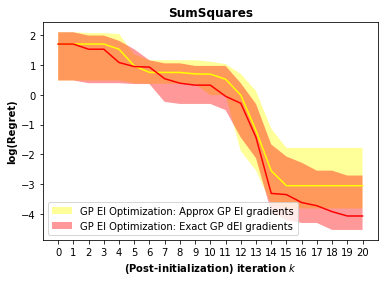

In [98]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Red')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI Optimization: Approx GP EI gradients')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='GP EI Optimization: Exact GP dEI gradients')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=3) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualize!

In [99]:
time_approx, time_exact


(1288.707580089569, 1210.0365204811096)

In [100]:
min_ei = 0


In [101]:
### acqFunc regret minimization: run number = 1

### Exact
acqFuncApprox_exact_1 = acqFuncApprox(exact_1.history) 
acqFuncExact_exact_1 = acqFuncExact(exact_1.history)

acqFuncApproxRegret_exact_1 = np.log(acqFuncApprox_exact_1 - min_ei)
acqFuncExactRegret_exact_1 = np.log(acqFuncExact_exact_1 - min_ei)

acqFuncApproxSimpleRegret_exact_1 = min_max_array(acqFuncApproxRegret_exact_1)
acqFuncExactSimpleRegret_exact_1 = min_max_array(acqFuncExactRegret_exact_1)

min_acqFuncApproxSimpleRegret_exact_1 = min(acqFuncApproxSimpleRegret_exact_1)
min_acqFuncExactSimpleRegret_exact_1 = min(acqFuncExactSimpleRegret_exact_1)

min_acqFuncApproxSimpleRegret_exact_1, min_acqFuncExactSimpleRegret_exact_1


(-0.8015725491306734, -1.3605546715621795)

In [102]:
### acqFunc regret minimization: run number = 2

### Exact
acqFuncApprox_exact_2 = acqFuncApprox(exact_2.history) 
acqFuncExact_exact_2 = acqFuncExact(exact_2.history)

acqFuncApproxRegret_exact_2 = np.log(acqFuncApprox_exact_2 - min_ei)
acqFuncExactRegret_exact_2 = np.log(acqFuncExact_exact_2 - min_ei)

acqFuncApproxSimpleRegret_exact_2 = min_max_array(acqFuncApproxRegret_exact_2)
acqFuncExactSimpleRegret_exact_2 = min_max_array(acqFuncExactRegret_exact_2)

min_acqFuncApproxSimpleRegret_exact_2 = min(acqFuncApproxSimpleRegret_exact_2)
min_acqFuncExactSimpleRegret_exact_2 = min(acqFuncExactSimpleRegret_exact_2)

min_acqFuncApproxSimpleRegret_exact_2, min_acqFuncExactSimpleRegret_exact_2


(-0.8813667489928393, -0.9677175435121941)

In [103]:
### acqFunc regret minimization: run number = 3

### Exact
acqFuncApprox_exact_3 = acqFuncApprox(exact_3.history) 
acqFuncExact_exact_3 = acqFuncExact(exact_3.history)

acqFuncApproxRegret_exact_3 = np.log(acqFuncApprox_exact_3 - min_ei)
acqFuncExactRegret_exact_3 = np.log(acqFuncExact_exact_3 - min_ei)

acqFuncApproxSimpleRegret_exact_3 = min_max_array(acqFuncApproxRegret_exact_3)
acqFuncExactSimpleRegret_exact_3 = min_max_array(acqFuncExactRegret_exact_3)

min_acqFuncApproxSimpleRegret_exact_3 = min(acqFuncApproxSimpleRegret_exact_3)
min_acqFuncExactSimpleRegret_exact_3 = min(acqFuncExactSimpleRegret_exact_3)

min_acqFuncApproxSimpleRegret_exact_3, min_acqFuncExactSimpleRegret_exact_3


(-0.82230618270454, -1.6250133816774852)

In [104]:
### acqFunc regret minimization: run number = 4

### Exact
acqFuncApprox_exact_4 = acqFuncApprox(exact_4.history) 
acqFuncExact_exact_4 = acqFuncExact(exact_4.history)

acqFuncApproxRegret_exact_4 = np.log(acqFuncApprox_exact_4 - min_ei)
acqFuncExactRegret_exact_4 = np.log(acqFuncExact_exact_4 - min_ei)

acqFuncApproxSimpleRegret_exact_4 = min_max_array(acqFuncApproxRegret_exact_4)
acqFuncExactSimpleRegret_exact_4 = min_max_array(acqFuncExactRegret_exact_4)

min_acqFuncApproxSimpleRegret_exact_4 = min(acqFuncApproxSimpleRegret_exact_4)
min_acqFuncExactSimpleRegret_exact_4 = min(acqFuncExactSimpleRegret_exact_4)

min_acqFuncApproxSimpleRegret_exact_4, min_acqFuncExactSimpleRegret_exact_4


(-0.7395443275626594, -1.3407227274224087)

In [105]:
### acqFunc regret minimization: run number = 5

### Exact
acqFuncApprox_exact_5 = acqFuncApprox(exact_5.history) 
acqFuncExact_exact_5 = acqFuncExact(exact_5.history)

acqFuncApproxRegret_exact_5 = np.log(acqFuncApprox_exact_5 - min_ei)
acqFuncExactRegret_exact_5 = np.log(acqFuncExact_exact_5 - min_ei)

acqFuncApproxSimpleRegret_exact_5 = min_max_array(acqFuncApproxRegret_exact_5)
acqFuncExactSimpleRegret_exact_5 = min_max_array(acqFuncExactRegret_exact_5)

min_acqFuncApproxSimpleRegret_exact_5 = min(acqFuncApproxSimpleRegret_exact_5)
min_acqFuncExactSimpleRegret_exact_5 = min(acqFuncExactSimpleRegret_exact_5)

min_acqFuncApproxSimpleRegret_exact_5, min_acqFuncExactSimpleRegret_exact_5


(-0.5901573952672553, -0.6247558900576585)

In [106]:
### acqFunc regret minimization: run number = 6

### Exact
acqFuncApprox_exact_6 = acqFuncApprox(exact_6.history) 
acqFuncExact_exact_6 = acqFuncExact(exact_6.history)

acqFuncApproxRegret_exact_6 = np.log(acqFuncApprox_exact_6 - min_ei)
acqFuncExactRegret_exact_6 = np.log(acqFuncExact_exact_6 - min_ei)

acqFuncApproxSimpleRegret_exact_6 = min_max_array(acqFuncApproxRegret_exact_6)
acqFuncExactSimpleRegret_exact_6 = min_max_array(acqFuncExactRegret_exact_6)

min_acqFuncApproxSimpleRegret_exact_6 = min(acqFuncApproxSimpleRegret_exact_6)
min_acqFuncExactSimpleRegret_exact_6 = min(acqFuncExactSimpleRegret_exact_6)

min_acqFuncApproxSimpleRegret_exact_6, min_acqFuncExactSimpleRegret_exact_6


(-0.8711510706258422, -3.5754286364222194)

In [107]:
### acqFunc regret minimization: run number = 7

### Exact
acqFuncApprox_exact_7 = acqFuncApprox(exact_7.history) 
acqFuncExact_exact_7 = acqFuncExact(exact_7.history)

acqFuncApproxRegret_exact_7 = np.log(acqFuncApprox_exact_7 - min_ei)
acqFuncExactRegret_exact_7 = np.log(acqFuncExact_exact_7 - min_ei)

acqFuncApproxSimpleRegret_exact_7 = min_max_array(acqFuncApproxRegret_exact_7)
acqFuncExactSimpleRegret_exact_7 = min_max_array(acqFuncExactRegret_exact_7)

min_acqFuncApproxSimpleRegret_exact_7 = min(acqFuncApproxSimpleRegret_exact_7)
min_acqFuncExactSimpleRegret_exact_7 = min(acqFuncExactSimpleRegret_exact_7)

min_acqFuncApproxSimpleRegret_exact_7, min_acqFuncExactSimpleRegret_exact_7


(-0.8483323935221393, -1.095557137368992)

In [108]:
### acqFunc regret minimization: run number = 8

### Exact
acqFuncApprox_exact_8 = acqFuncApprox(exact_8.history) 
acqFuncExact_exact_8 = acqFuncExact(exact_8.history)

acqFuncApproxRegret_exact_8 = np.log(acqFuncApprox_exact_8 - min_ei)
acqFuncExactRegret_exact_8 = np.log(acqFuncExact_exact_8 - min_ei)

acqFuncApproxSimpleRegret_exact_8 = min_max_array(acqFuncApproxRegret_exact_8)
acqFuncExactSimpleRegret_exact_8 = min_max_array(acqFuncExactRegret_exact_8)

min_acqFuncApproxSimpleRegret_exact_8 = min(acqFuncApproxSimpleRegret_exact_8)
min_acqFuncExactSimpleRegret_exact_8 = min(acqFuncExactSimpleRegret_exact_8)

min_acqFuncApproxSimpleRegret_exact_8, min_acqFuncExactSimpleRegret_exact_8


(-0.8907299357642506, -1.1541592500407902)

In [109]:
### acqFunc regret minimization: run number = 9

### Exact
acqFuncApprox_exact_9 = acqFuncApprox(exact_9.history) 
acqFuncExact_exact_9 = acqFuncExact(exact_9.history)

acqFuncApproxRegret_exact_9 = np.log(acqFuncApprox_exact_9 - min_ei)
acqFuncExactRegret_exact_9 = np.log(acqFuncExact_exact_9 - min_ei)

acqFuncApproxSimpleRegret_exact_9 = min_max_array(acqFuncApproxRegret_exact_9)
acqFuncExactSimpleRegret_exact_9 = min_max_array(acqFuncExactRegret_exact_9)

min_acqFuncApproxSimpleRegret_exact_9 = min(acqFuncApproxSimpleRegret_exact_9)
min_acqFuncExactSimpleRegret_exact_9 = min(acqFuncExactSimpleRegret_exact_9)

min_acqFuncApproxSimpleRegret_exact_9, min_acqFuncExactSimpleRegret_exact_9


(-0.6673331428986691, -0.7387320584812004)

In [110]:
### acqFunc regret minimization: run number = 10

### Exact
acqFuncApprox_exact_10 = acqFuncApprox(exact_10.history) 
acqFuncExact_exact_10 = acqFuncExact(exact_10.history)

acqFuncApproxRegret_exact_10 = np.log(acqFuncApprox_exact_10 - min_ei)
acqFuncExactRegret_exact_10 = np.log(acqFuncExact_exact_10 - min_ei)

acqFuncApproxSimpleRegret_exact_10 = min_max_array(acqFuncApproxRegret_exact_10)
acqFuncExactSimpleRegret_exact_10 = min_max_array(acqFuncExactRegret_exact_10)

min_acqFuncApproxSimpleRegret_exact_10 = min(acqFuncApproxSimpleRegret_exact_10)
min_acqFuncExactSimpleRegret_exact_10 = min(acqFuncExactSimpleRegret_exact_10)

min_acqFuncApproxSimpleRegret_exact_10, min_acqFuncExactSimpleRegret_exact_10


(-0.6503736888000095, -1.0117392615710632)

In [111]:
### acqFunc regret minimization: run number = 11

### Exact
acqFuncApprox_exact_11 = acqFuncApprox(exact_11.history) 
acqFuncExact_exact_11 = acqFuncExact(exact_11.history)

acqFuncApproxRegret_exact_11 = np.log(acqFuncApprox_exact_11 - min_ei)
acqFuncExactRegret_exact_11 = np.log(acqFuncExact_exact_11 - min_ei)

acqFuncApproxSimpleRegret_exact_11 = min_max_array(acqFuncApproxRegret_exact_11)
acqFuncExactSimpleRegret_exact_11 = min_max_array(acqFuncExactRegret_exact_11)

min_acqFuncApproxSimpleRegret_exact_11 = min(acqFuncApproxSimpleRegret_exact_11)
min_acqFuncExactSimpleRegret_exact_11 = min(acqFuncExactSimpleRegret_exact_11)

min_acqFuncApproxSimpleRegret_exact_11, min_acqFuncExactSimpleRegret_exact_11


(-0.8537313791050728, -1.626139354122451)

In [112]:
### acqFunc regret minimization: run number = 12

### Exact
acqFuncApprox_exact_12 = acqFuncApprox(exact_12.history) 
acqFuncExact_exact_12 = acqFuncExact(exact_12.history)

acqFuncApproxRegret_exact_12 = np.log(acqFuncApprox_exact_12 - min_ei)
acqFuncExactRegret_exact_12 = np.log(acqFuncExact_exact_12 - min_ei)

acqFuncApproxSimpleRegret_exact_12 = min_max_array(acqFuncApproxRegret_exact_12)
acqFuncExactSimpleRegret_exact_12 = min_max_array(acqFuncExactRegret_exact_12)

min_acqFuncApproxSimpleRegret_exact_12 = min(acqFuncApproxSimpleRegret_exact_12)
min_acqFuncExactSimpleRegret_exact_12 = min(acqFuncExactSimpleRegret_exact_12)

min_acqFuncApproxSimpleRegret_exact_12, min_acqFuncExactSimpleRegret_exact_12


(-0.9148497691675798, -1.5946971752349839)

In [113]:
### acqFunc regret minimization: run number = 13

### Exact
acqFuncApprox_exact_13 = acqFuncApprox(exact_13.history) 
acqFuncExact_exact_13 = acqFuncExact(exact_13.history)

acqFuncApproxRegret_exact_13 = np.log(acqFuncApprox_exact_13 - min_ei)
acqFuncExactRegret_exact_13 = np.log(acqFuncExact_exact_13 - min_ei)

acqFuncApproxSimpleRegret_exact_13 = min_max_array(acqFuncApproxRegret_exact_13)
acqFuncExactSimpleRegret_exact_13 = min_max_array(acqFuncExactRegret_exact_13)

min_acqFuncApproxSimpleRegret_exact_13 = min(acqFuncApproxSimpleRegret_exact_13)
min_acqFuncExactSimpleRegret_exact_13 = min(acqFuncExactSimpleRegret_exact_13)

min_acqFuncApproxSimpleRegret_exact_13, min_acqFuncExactSimpleRegret_exact_13


(-0.9314387996373173, -1.9866770079639113)

In [114]:
### acqFunc regret minimization: run number = 14

### Exact
acqFuncApprox_exact_14 = acqFuncApprox(exact_14.history) 
acqFuncExact_exact_14 = acqFuncExact(exact_14.history)

acqFuncApproxRegret_exact_14 = np.log(acqFuncApprox_exact_14 - min_ei)
acqFuncExactRegret_exact_14 = np.log(acqFuncExact_exact_14 - min_ei)

acqFuncApproxSimpleRegret_exact_14 = min_max_array(acqFuncApproxRegret_exact_14)
acqFuncExactSimpleRegret_exact_14 = min_max_array(acqFuncExactRegret_exact_14)

min_acqFuncApproxSimpleRegret_exact_14 = min(acqFuncApproxSimpleRegret_exact_14)
min_acqFuncExactSimpleRegret_exact_14 = min(acqFuncExactSimpleRegret_exact_14)

min_acqFuncApproxSimpleRegret_exact_14, min_acqFuncExactSimpleRegret_exact_14


(-0.7561686580585293, -1.1520806474690044)

In [115]:
### acqFunc regret minimization: run number = 15

### Exact
acqFuncApprox_exact_15 = acqFuncApprox(exact_15.history) 
acqFuncExact_exact_15 = acqFuncExact(exact_15.history)

acqFuncApproxRegret_exact_15 = np.log(acqFuncApprox_exact_15 - min_ei)
acqFuncExactRegret_exact_15 = np.log(acqFuncExact_exact_15 - min_ei)

acqFuncApproxSimpleRegret_exact_15 = min_max_array(acqFuncApproxRegret_exact_15)
acqFuncExactSimpleRegret_exact_15 = min_max_array(acqFuncExactRegret_exact_15)

min_acqFuncApproxSimpleRegret_exact_15 = min(acqFuncApproxSimpleRegret_exact_15)
min_acqFuncExactSimpleRegret_exact_15 = min(acqFuncExactSimpleRegret_exact_15)

min_acqFuncApproxSimpleRegret_exact_15, min_acqFuncExactSimpleRegret_exact_15


(-0.9141521332296947, -1.5551023822281471)

In [116]:
### acqFunc regret minimization: run number = 16

### Exact
acqFuncApprox_exact_16 = acqFuncApprox(exact_16.history) 
acqFuncExact_exact_16 = acqFuncExact(exact_16.history)

acqFuncApproxRegret_exact_16 = np.log(acqFuncApprox_exact_16 - min_ei)
acqFuncExactRegret_exact_16 = np.log(acqFuncExact_exact_16 - min_ei)

acqFuncApproxSimpleRegret_exact_16 = min_max_array(acqFuncApproxRegret_exact_16)
acqFuncExactSimpleRegret_exact_16 = min_max_array(acqFuncExactRegret_exact_16)

min_acqFuncApproxSimpleRegret_exact_16 = min(acqFuncApproxSimpleRegret_exact_16)
min_acqFuncExactSimpleRegret_exact_16 = min(acqFuncExactSimpleRegret_exact_16)

min_acqFuncApproxSimpleRegret_exact_16, min_acqFuncExactSimpleRegret_exact_16


(-0.7025350523483779, -1.0271242992635228)

In [117]:
### acqFunc regret minimization: run number = 17

### Exact
acqFuncApprox_exact_17 = acqFuncApprox(exact_17.history) 
acqFuncExact_exact_17 = acqFuncExact(exact_17.history)

acqFuncApproxRegret_exact_17 = np.log(acqFuncApprox_exact_17 - min_ei)
acqFuncExactRegret_exact_17 = np.log(acqFuncExact_exact_17 - min_ei)

acqFuncApproxSimpleRegret_exact_17 = min_max_array(acqFuncApproxRegret_exact_17)
acqFuncExactSimpleRegret_exact_17 = min_max_array(acqFuncExactRegret_exact_17)

min_acqFuncApproxSimpleRegret_exact_17 = min(acqFuncApproxSimpleRegret_exact_17)
min_acqFuncExactSimpleRegret_exact_17 = min(acqFuncExactSimpleRegret_exact_17)

min_acqFuncApproxSimpleRegret_exact_17, min_acqFuncExactSimpleRegret_exact_17


(-0.8958303215808955, -1.2237784024163763)

In [118]:
### acqFunc regret minimization: run number = 18

### Exact
acqFuncApprox_exact_18 = acqFuncApprox(exact_18.history) 
acqFuncExact_exact_18 = acqFuncExact(exact_18.history)

acqFuncApproxRegret_exact_18 = np.log(acqFuncApprox_exact_18 - min_ei)
acqFuncExactRegret_exact_18 = np.log(acqFuncExact_exact_18 - min_ei)

acqFuncApproxSimpleRegret_exact_18 = min_max_array(acqFuncApproxRegret_exact_18)
acqFuncExactSimpleRegret_exact_18 = min_max_array(acqFuncExactRegret_exact_18)

min_acqFuncApproxSimpleRegret_exact_18 = min(acqFuncApproxSimpleRegret_exact_18)
min_acqFuncExactSimpleRegret_exact_18 = min(acqFuncExactSimpleRegret_exact_18)

min_acqFuncApproxSimpleRegret_exact_18, min_acqFuncExactSimpleRegret_exact_18


(-0.8110090915173664, -1.241950350025653)

In [119]:
### acqFunc regret minimization: run number = 19

### Exact
acqFuncApprox_exact_19 = acqFuncApprox(exact_19.history) 
acqFuncExact_exact_19 = acqFuncExact(exact_19.history)

acqFuncApproxRegret_exact_19 = np.log(acqFuncApprox_exact_19 - min_ei)
acqFuncExactRegret_exact_19 = np.log(acqFuncExact_exact_19 - min_ei)

acqFuncApproxSimpleRegret_exact_19 = min_max_array(acqFuncApproxRegret_exact_19)
acqFuncExactSimpleRegret_exact_19 = min_max_array(acqFuncExactRegret_exact_19)

min_acqFuncApproxSimpleRegret_exact_19 = min(acqFuncApproxSimpleRegret_exact_19)
min_acqFuncExactSimpleRegret_exact_19 = min(acqFuncExactSimpleRegret_exact_19)

min_acqFuncApproxSimpleRegret_exact_19, min_acqFuncExactSimpleRegret_exact_19


(-0.7194594177712641, -1.2631287475406874)

In [120]:
### acqFunc regret minimization: run number = 20

### Exact
acqFuncApprox_exact_20 = acqFuncApprox(exact_20.history) 
acqFuncExact_exact_20 = acqFuncExact(exact_20.history)

acqFuncApproxRegret_exact_20 = np.log(acqFuncApprox_exact_20 - min_ei)
acqFuncExactRegret_exact_20 = np.log(acqFuncExact_exact_20 - min_ei)

acqFuncApproxSimpleRegret_exact_20 = min_max_array(acqFuncApproxRegret_exact_20)
acqFuncExactSimpleRegret_exact_20 = min_max_array(acqFuncExactRegret_exact_20)

min_acqFuncApproxSimpleRegret_exact_20 = min(acqFuncApproxSimpleRegret_exact_20)
min_acqFuncExactSimpleRegret_exact_20 = min(acqFuncExactSimpleRegret_exact_20)

min_acqFuncApproxSimpleRegret_exact_20, min_acqFuncExactSimpleRegret_exact_20


(-0.9337581905024771, -1.3344371389926437)

In [121]:
# Iteration1 :

ApproxSimpleRegret_exact1 = [acqFuncApproxSimpleRegret_exact_1[slice1],
                              acqFuncApproxSimpleRegret_exact_2[slice1],
                              acqFuncApproxSimpleRegret_exact_3[slice1],
                              acqFuncApproxSimpleRegret_exact_4[slice1],
                              acqFuncApproxSimpleRegret_exact_5[slice1],
                              acqFuncApproxSimpleRegret_exact_6[slice1],
                              acqFuncApproxSimpleRegret_exact_7[slice1],
                              acqFuncApproxSimpleRegret_exact_8[slice1],
                              acqFuncApproxSimpleRegret_exact_9[slice1],
                              acqFuncApproxSimpleRegret_exact_10[slice1],
                              acqFuncApproxSimpleRegret_exact_11[slice1],
                              acqFuncApproxSimpleRegret_exact_12[slice1],
                              acqFuncApproxSimpleRegret_exact_13[slice1],
                              acqFuncApproxSimpleRegret_exact_14[slice1],
                              acqFuncApproxSimpleRegret_exact_15[slice1],
                              acqFuncApproxSimpleRegret_exact_16[slice1],
                              acqFuncApproxSimpleRegret_exact_17[slice1],
                              acqFuncApproxSimpleRegret_exact_18[slice1],
                              acqFuncApproxSimpleRegret_exact_19[slice1],
                              acqFuncApproxSimpleRegret_exact_20[slice1]]

ExactSimpleRegret_exact1 = [acqFuncExactSimpleRegret_exact_1[slice1],
                              acqFuncExactSimpleRegret_exact_2[slice1],
                              acqFuncExactSimpleRegret_exact_3[slice1],
                              acqFuncExactSimpleRegret_exact_4[slice1],
                              acqFuncExactSimpleRegret_exact_5[slice1],
                              acqFuncExactSimpleRegret_exact_6[slice1],
                              acqFuncExactSimpleRegret_exact_7[slice1],
                              acqFuncExactSimpleRegret_exact_8[slice1],
                              acqFuncExactSimpleRegret_exact_9[slice1],
                              acqFuncExactSimpleRegret_exact_10[slice1],
                              acqFuncExactSimpleRegret_exact_11[slice1],
                              acqFuncExactSimpleRegret_exact_12[slice1],
                              acqFuncExactSimpleRegret_exact_13[slice1],
                              acqFuncExactSimpleRegret_exact_14[slice1],
                              acqFuncExactSimpleRegret_exact_15[slice1],
                              acqFuncExactSimpleRegret_exact_16[slice1],
                              acqFuncExactSimpleRegret_exact_17[slice1],
                              acqFuncExactSimpleRegret_exact_18[slice1],
                              acqFuncExactSimpleRegret_exact_19[slice1],
                              acqFuncExactSimpleRegret_exact_20[slice1]]

ApproxSimpleRegret_exact1_results = pd.DataFrame(ApproxSimpleRegret_exact1).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact1_results = pd.DataFrame(ExactSimpleRegret_exact1).sort_values(by=[0], ascending=False)


### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact1 = np.asarray(ApproxSimpleRegret_exact1_results[4:5][0])[0]
median_ApproxSimpleRegret_exact1 = np.asarray(ApproxSimpleRegret_exact1_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact1 = np.asarray(ApproxSimpleRegret_exact1_results[14:15][0])[0]

lower_ExactSimpleRegret_exact1 = np.asarray(ExactSimpleRegret_exact1_results[4:5][0])[0]
median_ExactSimpleRegret_exact1 = np.asarray(ExactSimpleRegret_exact1_results[9:10][0])[0]
upper_ExactSimpleRegret_exact1 = np.asarray(ExactSimpleRegret_exact1_results[14:15][0])[0]


In [122]:
# Iteration2 :

ApproxSimpleRegret_exact2 = [acqFuncApproxSimpleRegret_exact_1[slice2],
                              acqFuncApproxSimpleRegret_exact_2[slice2],
                              acqFuncApproxSimpleRegret_exact_3[slice2],
                              acqFuncApproxSimpleRegret_exact_4[slice2],
                              acqFuncApproxSimpleRegret_exact_5[slice2],
                              acqFuncApproxSimpleRegret_exact_6[slice2],
                              acqFuncApproxSimpleRegret_exact_7[slice2],
                              acqFuncApproxSimpleRegret_exact_8[slice2],
                              acqFuncApproxSimpleRegret_exact_9[slice2],
                              acqFuncApproxSimpleRegret_exact_10[slice2],
                              acqFuncApproxSimpleRegret_exact_11[slice2],
                              acqFuncApproxSimpleRegret_exact_12[slice2],
                              acqFuncApproxSimpleRegret_exact_13[slice2],
                              acqFuncApproxSimpleRegret_exact_14[slice2],
                              acqFuncApproxSimpleRegret_exact_15[slice2],
                              acqFuncApproxSimpleRegret_exact_16[slice2],
                              acqFuncApproxSimpleRegret_exact_17[slice2],
                              acqFuncApproxSimpleRegret_exact_18[slice2],
                              acqFuncApproxSimpleRegret_exact_19[slice2],
                              acqFuncApproxSimpleRegret_exact_20[slice2]]

ExactSimpleRegret_exact2 = [acqFuncExactSimpleRegret_exact_1[slice2],
                              acqFuncExactSimpleRegret_exact_2[slice2],
                              acqFuncExactSimpleRegret_exact_3[slice2],
                              acqFuncExactSimpleRegret_exact_4[slice2],
                              acqFuncExactSimpleRegret_exact_5[slice2],
                              acqFuncExactSimpleRegret_exact_6[slice2],
                              acqFuncExactSimpleRegret_exact_7[slice2],
                              acqFuncExactSimpleRegret_exact_8[slice2],
                              acqFuncExactSimpleRegret_exact_9[slice2],
                              acqFuncExactSimpleRegret_exact_10[slice2],
                              acqFuncExactSimpleRegret_exact_11[slice2],
                              acqFuncExactSimpleRegret_exact_12[slice2],
                              acqFuncExactSimpleRegret_exact_13[slice2],
                              acqFuncExactSimpleRegret_exact_14[slice2],
                              acqFuncExactSimpleRegret_exact_15[slice2],
                              acqFuncExactSimpleRegret_exact_16[slice2],
                              acqFuncExactSimpleRegret_exact_17[slice2],
                              acqFuncExactSimpleRegret_exact_18[slice2],
                              acqFuncExactSimpleRegret_exact_19[slice2],
                              acqFuncExactSimpleRegret_exact_20[slice2]]

ApproxSimpleRegret_exact2_results = pd.DataFrame(ApproxSimpleRegret_exact2).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact2_results = pd.DataFrame(ExactSimpleRegret_exact2).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact2 = np.asarray(ApproxSimpleRegret_exact2_results[4:5][0])[0]
median_ApproxSimpleRegret_exact2 = np.asarray(ApproxSimpleRegret_exact2_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact2 = np.asarray(ApproxSimpleRegret_exact2_results[14:15][0])[0]

lower_ExactSimpleRegret_exact2 = np.asarray(ExactSimpleRegret_exact2_results[4:5][0])[0]
median_ExactSimpleRegret_exact2 = np.asarray(ExactSimpleRegret_exact2_results[9:10][0])[0]
upper_ExactSimpleRegret_exact2 = np.asarray(ExactSimpleRegret_exact2_results[14:15][0])[0]


In [123]:
# Iteration3 :

ApproxSimpleRegret_exact3 = [acqFuncApproxSimpleRegret_exact_1[slice3],
                              acqFuncApproxSimpleRegret_exact_2[slice3],
                              acqFuncApproxSimpleRegret_exact_3[slice3],
                              acqFuncApproxSimpleRegret_exact_4[slice3],
                              acqFuncApproxSimpleRegret_exact_5[slice3],
                              acqFuncApproxSimpleRegret_exact_6[slice3],
                              acqFuncApproxSimpleRegret_exact_7[slice3],
                              acqFuncApproxSimpleRegret_exact_8[slice3],
                              acqFuncApproxSimpleRegret_exact_9[slice3],
                              acqFuncApproxSimpleRegret_exact_10[slice3],
                              acqFuncApproxSimpleRegret_exact_11[slice3],
                              acqFuncApproxSimpleRegret_exact_12[slice3],
                              acqFuncApproxSimpleRegret_exact_13[slice3],
                              acqFuncApproxSimpleRegret_exact_14[slice3],
                              acqFuncApproxSimpleRegret_exact_15[slice3],
                              acqFuncApproxSimpleRegret_exact_16[slice3],
                              acqFuncApproxSimpleRegret_exact_17[slice3],
                              acqFuncApproxSimpleRegret_exact_18[slice3],
                              acqFuncApproxSimpleRegret_exact_19[slice3],
                              acqFuncApproxSimpleRegret_exact_20[slice3]]

ExactSimpleRegret_exact3 = [acqFuncExactSimpleRegret_exact_1[slice3],
                              acqFuncExactSimpleRegret_exact_2[slice3],
                              acqFuncExactSimpleRegret_exact_3[slice3],
                              acqFuncExactSimpleRegret_exact_4[slice3],
                              acqFuncExactSimpleRegret_exact_5[slice3],
                              acqFuncExactSimpleRegret_exact_6[slice3],
                              acqFuncExactSimpleRegret_exact_7[slice3],
                              acqFuncExactSimpleRegret_exact_8[slice3],
                              acqFuncExactSimpleRegret_exact_9[slice3],
                              acqFuncExactSimpleRegret_exact_10[slice3],
                              acqFuncExactSimpleRegret_exact_11[slice3],
                              acqFuncExactSimpleRegret_exact_12[slice3],
                              acqFuncExactSimpleRegret_exact_13[slice3],
                              acqFuncExactSimpleRegret_exact_14[slice3],
                              acqFuncExactSimpleRegret_exact_15[slice3],
                              acqFuncExactSimpleRegret_exact_16[slice3],
                              acqFuncExactSimpleRegret_exact_17[slice3],
                              acqFuncExactSimpleRegret_exact_18[slice3],
                              acqFuncExactSimpleRegret_exact_19[slice3],
                              acqFuncExactSimpleRegret_exact_20[slice3]]

ApproxSimpleRegret_exact3_results = pd.DataFrame(ApproxSimpleRegret_exact3).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact3_results = pd.DataFrame(ExactSimpleRegret_exact3).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact3 = np.asarray(ApproxSimpleRegret_exact3_results[4:5][0])[0]
median_ApproxSimpleRegret_exact3 = np.asarray(ApproxSimpleRegret_exact3_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact3 = np.asarray(ApproxSimpleRegret_exact3_results[14:15][0])[0]

lower_ExactSimpleRegret_exact3 = np.asarray(ExactSimpleRegret_exact3_results[4:5][0])[0]
median_ExactSimpleRegret_exact3 = np.asarray(ExactSimpleRegret_exact3_results[9:10][0])[0]
upper_ExactSimpleRegret_exact3 = np.asarray(ExactSimpleRegret_exact3_results[14:15][0])[0]


In [124]:
# Iteration4 :

ApproxSimpleRegret_exact4 = [acqFuncApproxSimpleRegret_exact_1[slice4],
                              acqFuncApproxSimpleRegret_exact_2[slice4],
                              acqFuncApproxSimpleRegret_exact_3[slice4],
                              acqFuncApproxSimpleRegret_exact_4[slice4],
                              acqFuncApproxSimpleRegret_exact_5[slice4],
                              acqFuncApproxSimpleRegret_exact_6[slice4],
                              acqFuncApproxSimpleRegret_exact_7[slice4],
                              acqFuncApproxSimpleRegret_exact_8[slice4],
                              acqFuncApproxSimpleRegret_exact_9[slice4],
                              acqFuncApproxSimpleRegret_exact_10[slice4],
                              acqFuncApproxSimpleRegret_exact_11[slice4],
                              acqFuncApproxSimpleRegret_exact_12[slice4],
                              acqFuncApproxSimpleRegret_exact_13[slice4],
                              acqFuncApproxSimpleRegret_exact_14[slice4],
                              acqFuncApproxSimpleRegret_exact_15[slice4],
                              acqFuncApproxSimpleRegret_exact_16[slice4],
                              acqFuncApproxSimpleRegret_exact_17[slice4],
                              acqFuncApproxSimpleRegret_exact_18[slice4],
                              acqFuncApproxSimpleRegret_exact_19[slice4],
                              acqFuncApproxSimpleRegret_exact_20[slice4]]

ExactSimpleRegret_exact4 = [acqFuncExactSimpleRegret_exact_1[slice4],
                              acqFuncExactSimpleRegret_exact_2[slice4],
                              acqFuncExactSimpleRegret_exact_3[slice4],
                              acqFuncExactSimpleRegret_exact_4[slice4],
                              acqFuncExactSimpleRegret_exact_5[slice4],
                              acqFuncExactSimpleRegret_exact_6[slice4],
                              acqFuncExactSimpleRegret_exact_7[slice4],
                              acqFuncExactSimpleRegret_exact_8[slice4],
                              acqFuncExactSimpleRegret_exact_9[slice4],
                              acqFuncExactSimpleRegret_exact_10[slice4],
                              acqFuncExactSimpleRegret_exact_11[slice4],
                              acqFuncExactSimpleRegret_exact_12[slice4],
                              acqFuncExactSimpleRegret_exact_13[slice4],
                              acqFuncExactSimpleRegret_exact_14[slice4],
                              acqFuncExactSimpleRegret_exact_15[slice4],
                              acqFuncExactSimpleRegret_exact_16[slice4],
                              acqFuncExactSimpleRegret_exact_17[slice4],
                              acqFuncExactSimpleRegret_exact_18[slice4],
                              acqFuncExactSimpleRegret_exact_19[slice4],
                              acqFuncExactSimpleRegret_exact_20[slice4]]

ApproxSimpleRegret_exact4_results = pd.DataFrame(ApproxSimpleRegret_exact4).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact4_results = pd.DataFrame(ExactSimpleRegret_exact4).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact4 = np.asarray(ApproxSimpleRegret_exact4_results[4:5][0])[0]
median_ApproxSimpleRegret_exact4 = np.asarray(ApproxSimpleRegret_exact4_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact4 = np.asarray(ApproxSimpleRegret_exact4_results[14:15][0])[0]

lower_ExactSimpleRegret_exact4 = np.asarray(ExactSimpleRegret_exact4_results[4:5][0])[0]
median_ExactSimpleRegret_exact4 = np.asarray(ExactSimpleRegret_exact4_results[9:10][0])[0]
upper_ExactSimpleRegret_exact4 = np.asarray(ExactSimpleRegret_exact4_results[14:15][0])[0]


In [125]:
# Iteration5 :

ApproxSimpleRegret_exact5 = [acqFuncApproxSimpleRegret_exact_1[slice5],
                              acqFuncApproxSimpleRegret_exact_2[slice5],
                              acqFuncApproxSimpleRegret_exact_3[slice5],
                              acqFuncApproxSimpleRegret_exact_4[slice5],
                              acqFuncApproxSimpleRegret_exact_5[slice5],
                              acqFuncApproxSimpleRegret_exact_6[slice5],
                              acqFuncApproxSimpleRegret_exact_7[slice5],
                              acqFuncApproxSimpleRegret_exact_8[slice5],
                              acqFuncApproxSimpleRegret_exact_9[slice5],
                              acqFuncApproxSimpleRegret_exact_10[slice5],
                              acqFuncApproxSimpleRegret_exact_11[slice5],
                              acqFuncApproxSimpleRegret_exact_12[slice5],
                              acqFuncApproxSimpleRegret_exact_13[slice5],
                              acqFuncApproxSimpleRegret_exact_14[slice5],
                              acqFuncApproxSimpleRegret_exact_15[slice5],
                              acqFuncApproxSimpleRegret_exact_16[slice5],
                              acqFuncApproxSimpleRegret_exact_17[slice5],
                              acqFuncApproxSimpleRegret_exact_18[slice5],
                              acqFuncApproxSimpleRegret_exact_19[slice5],
                              acqFuncApproxSimpleRegret_exact_20[slice5]]

ExactSimpleRegret_exact5 = [acqFuncExactSimpleRegret_exact_1[slice5],
                              acqFuncExactSimpleRegret_exact_2[slice5],
                              acqFuncExactSimpleRegret_exact_3[slice5],
                              acqFuncExactSimpleRegret_exact_4[slice5],
                              acqFuncExactSimpleRegret_exact_5[slice5],
                              acqFuncExactSimpleRegret_exact_6[slice5],
                              acqFuncExactSimpleRegret_exact_7[slice5],
                              acqFuncExactSimpleRegret_exact_8[slice5],
                              acqFuncExactSimpleRegret_exact_9[slice5],
                              acqFuncExactSimpleRegret_exact_10[slice5],
                              acqFuncExactSimpleRegret_exact_11[slice5],
                              acqFuncExactSimpleRegret_exact_12[slice5],
                              acqFuncExactSimpleRegret_exact_13[slice5],
                              acqFuncExactSimpleRegret_exact_14[slice5],
                              acqFuncExactSimpleRegret_exact_15[slice5],
                              acqFuncExactSimpleRegret_exact_16[slice5],
                              acqFuncExactSimpleRegret_exact_17[slice5],
                              acqFuncExactSimpleRegret_exact_18[slice5],
                              acqFuncExactSimpleRegret_exact_19[slice5],
                              acqFuncExactSimpleRegret_exact_20[slice5]]

ApproxSimpleRegret_exact5_results = pd.DataFrame(ApproxSimpleRegret_exact5).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact5_results = pd.DataFrame(ExactSimpleRegret_exact5).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact5 = np.asarray(ApproxSimpleRegret_exact5_results[4:5][0])[0]
median_ApproxSimpleRegret_exact5 = np.asarray(ApproxSimpleRegret_exact5_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact5 = np.asarray(ApproxSimpleRegret_exact5_results[14:15][0])[0]

lower_ExactSimpleRegret_exact5 = np.asarray(ExactSimpleRegret_exact5_results[4:5][0])[0]
median_ExactSimpleRegret_exact5 = np.asarray(ExactSimpleRegret_exact5_results[9:10][0])[0]
upper_ExactSimpleRegret_exact5 = np.asarray(ExactSimpleRegret_exact5_results[14:15][0])[0]


In [126]:
# Iteration6 :

ApproxSimpleRegret_exact6 = [acqFuncApproxSimpleRegret_exact_1[slice6],
                              acqFuncApproxSimpleRegret_exact_2[slice6],
                              acqFuncApproxSimpleRegret_exact_3[slice6],
                              acqFuncApproxSimpleRegret_exact_4[slice6],
                              acqFuncApproxSimpleRegret_exact_5[slice6],
                              acqFuncApproxSimpleRegret_exact_6[slice6],
                              acqFuncApproxSimpleRegret_exact_7[slice6],
                              acqFuncApproxSimpleRegret_exact_8[slice6],
                              acqFuncApproxSimpleRegret_exact_9[slice6],
                              acqFuncApproxSimpleRegret_exact_10[slice6],
                              acqFuncApproxSimpleRegret_exact_11[slice6],
                              acqFuncApproxSimpleRegret_exact_12[slice6],
                              acqFuncApproxSimpleRegret_exact_13[slice6],
                              acqFuncApproxSimpleRegret_exact_14[slice6],
                              acqFuncApproxSimpleRegret_exact_15[slice6],
                              acqFuncApproxSimpleRegret_exact_16[slice6],
                              acqFuncApproxSimpleRegret_exact_17[slice6],
                              acqFuncApproxSimpleRegret_exact_18[slice6],
                              acqFuncApproxSimpleRegret_exact_19[slice6],
                              acqFuncApproxSimpleRegret_exact_20[slice6]]

ExactSimpleRegret_exact6 = [acqFuncExactSimpleRegret_exact_1[slice6],
                              acqFuncExactSimpleRegret_exact_2[slice6],
                              acqFuncExactSimpleRegret_exact_3[slice6],
                              acqFuncExactSimpleRegret_exact_4[slice6],
                              acqFuncExactSimpleRegret_exact_5[slice6],
                              acqFuncExactSimpleRegret_exact_6[slice6],
                              acqFuncExactSimpleRegret_exact_7[slice6],
                              acqFuncExactSimpleRegret_exact_8[slice6],
                              acqFuncExactSimpleRegret_exact_9[slice6],
                              acqFuncExactSimpleRegret_exact_10[slice6],
                              acqFuncExactSimpleRegret_exact_11[slice6],
                              acqFuncExactSimpleRegret_exact_12[slice6],
                              acqFuncExactSimpleRegret_exact_13[slice6],
                              acqFuncExactSimpleRegret_exact_14[slice6],
                              acqFuncExactSimpleRegret_exact_15[slice6],
                              acqFuncExactSimpleRegret_exact_16[slice6],
                              acqFuncExactSimpleRegret_exact_17[slice6],
                              acqFuncExactSimpleRegret_exact_18[slice6],
                              acqFuncExactSimpleRegret_exact_19[slice6],
                              acqFuncExactSimpleRegret_exact_20[slice6]]

ApproxSimpleRegret_exact6_results = pd.DataFrame(ApproxSimpleRegret_exact6).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact6_results = pd.DataFrame(ExactSimpleRegret_exact6).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact6 = np.asarray(ApproxSimpleRegret_exact6_results[4:5][0])[0]
median_ApproxSimpleRegret_exact6 = np.asarray(ApproxSimpleRegret_exact6_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact6 = np.asarray(ApproxSimpleRegret_exact6_results[14:15][0])[0]

lower_ExactSimpleRegret_exact6 = np.asarray(ExactSimpleRegret_exact6_results[4:5][0])[0]
median_ExactSimpleRegret_exact6 = np.asarray(ExactSimpleRegret_exact6_results[9:10][0])[0]
upper_ExactSimpleRegret_exact6 = np.asarray(ExactSimpleRegret_exact6_results[14:15][0])[0]


In [127]:
# Iteration7 :

ApproxSimpleRegret_exact7 =  [acqFuncApproxSimpleRegret_exact_1[slice7],
                              acqFuncApproxSimpleRegret_exact_2[slice7],
                              acqFuncApproxSimpleRegret_exact_3[slice7],
                              acqFuncApproxSimpleRegret_exact_4[slice7],
                              acqFuncApproxSimpleRegret_exact_5[slice7],
                              acqFuncApproxSimpleRegret_exact_6[slice7],
                              acqFuncApproxSimpleRegret_exact_7[slice7],
                              acqFuncApproxSimpleRegret_exact_8[slice7],
                              acqFuncApproxSimpleRegret_exact_9[slice7],
                              acqFuncApproxSimpleRegret_exact_10[slice7],
                              acqFuncApproxSimpleRegret_exact_11[slice7],
                              acqFuncApproxSimpleRegret_exact_12[slice7],
                              acqFuncApproxSimpleRegret_exact_13[slice7],
                              acqFuncApproxSimpleRegret_exact_14[slice7],
                              acqFuncApproxSimpleRegret_exact_15[slice7],
                              acqFuncApproxSimpleRegret_exact_16[slice7],
                              acqFuncApproxSimpleRegret_exact_17[slice7],
                              acqFuncApproxSimpleRegret_exact_18[slice7],
                              acqFuncApproxSimpleRegret_exact_19[slice7],
                              acqFuncApproxSimpleRegret_exact_20[slice7]]

ExactSimpleRegret_exact7 = [acqFuncExactSimpleRegret_exact_1[slice7],
                              acqFuncExactSimpleRegret_exact_2[slice7],
                              acqFuncExactSimpleRegret_exact_3[slice7],
                              acqFuncExactSimpleRegret_exact_4[slice7],
                              acqFuncExactSimpleRegret_exact_5[slice7],
                              acqFuncExactSimpleRegret_exact_6[slice7],
                              acqFuncExactSimpleRegret_exact_7[slice7],
                              acqFuncExactSimpleRegret_exact_8[slice7],
                              acqFuncExactSimpleRegret_exact_9[slice7],
                              acqFuncExactSimpleRegret_exact_10[slice7],
                              acqFuncExactSimpleRegret_exact_11[slice7],
                              acqFuncExactSimpleRegret_exact_12[slice7],
                              acqFuncExactSimpleRegret_exact_13[slice7],
                              acqFuncExactSimpleRegret_exact_14[slice7],
                              acqFuncExactSimpleRegret_exact_15[slice7],
                              acqFuncExactSimpleRegret_exact_16[slice7],
                              acqFuncExactSimpleRegret_exact_17[slice7],
                              acqFuncExactSimpleRegret_exact_18[slice7],
                              acqFuncExactSimpleRegret_exact_19[slice7],
                              acqFuncExactSimpleRegret_exact_20[slice7]]

ApproxSimpleRegret_exact7_results = pd.DataFrame(ApproxSimpleRegret_exact7).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact7_results = pd.DataFrame(ExactSimpleRegret_exact7).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact7 = np.asarray(ApproxSimpleRegret_exact7_results[4:5][0])[0]
median_ApproxSimpleRegret_exact7 = np.asarray(ApproxSimpleRegret_exact7_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact7 = np.asarray(ApproxSimpleRegret_exact7_results[14:15][0])[0]

lower_ExactSimpleRegret_exact7 = np.asarray(ExactSimpleRegret_exact7_results[4:5][0])[0]
median_ExactSimpleRegret_exact7 = np.asarray(ExactSimpleRegret_exact7_results[9:10][0])[0]
upper_ExactSimpleRegret_exact7 = np.asarray(ExactSimpleRegret_exact7_results[14:15][0])[0]


In [128]:
# Iteration8 :

ApproxSimpleRegret_exact8 =  [acqFuncApproxSimpleRegret_exact_1[slice8],
                              acqFuncApproxSimpleRegret_exact_2[slice8],
                              acqFuncApproxSimpleRegret_exact_3[slice8],
                              acqFuncApproxSimpleRegret_exact_4[slice8],
                              acqFuncApproxSimpleRegret_exact_5[slice8],
                              acqFuncApproxSimpleRegret_exact_6[slice8],
                              acqFuncApproxSimpleRegret_exact_7[slice8],
                              acqFuncApproxSimpleRegret_exact_8[slice8],
                              acqFuncApproxSimpleRegret_exact_9[slice8],
                              acqFuncApproxSimpleRegret_exact_10[slice8],
                              acqFuncApproxSimpleRegret_exact_11[slice8],
                              acqFuncApproxSimpleRegret_exact_12[slice8],
                              acqFuncApproxSimpleRegret_exact_13[slice8],
                              acqFuncApproxSimpleRegret_exact_14[slice8],
                              acqFuncApproxSimpleRegret_exact_15[slice8],
                              acqFuncApproxSimpleRegret_exact_16[slice8],
                              acqFuncApproxSimpleRegret_exact_17[slice8],
                              acqFuncApproxSimpleRegret_exact_18[slice8],
                              acqFuncApproxSimpleRegret_exact_19[slice8],
                              acqFuncApproxSimpleRegret_exact_20[slice8]]

ExactSimpleRegret_exact8 = [acqFuncExactSimpleRegret_exact_1[slice8],
                              acqFuncExactSimpleRegret_exact_2[slice8],
                              acqFuncExactSimpleRegret_exact_3[slice8],
                              acqFuncExactSimpleRegret_exact_4[slice8],
                              acqFuncExactSimpleRegret_exact_5[slice8],
                              acqFuncExactSimpleRegret_exact_6[slice8],
                              acqFuncExactSimpleRegret_exact_7[slice8],
                              acqFuncExactSimpleRegret_exact_8[slice8],
                              acqFuncExactSimpleRegret_exact_9[slice8],
                              acqFuncExactSimpleRegret_exact_10[slice8],
                              acqFuncExactSimpleRegret_exact_11[slice8],
                              acqFuncExactSimpleRegret_exact_12[slice8],
                              acqFuncExactSimpleRegret_exact_13[slice8],
                              acqFuncExactSimpleRegret_exact_14[slice8],
                              acqFuncExactSimpleRegret_exact_15[slice8],
                              acqFuncExactSimpleRegret_exact_16[slice8],
                              acqFuncExactSimpleRegret_exact_17[slice8],
                              acqFuncExactSimpleRegret_exact_18[slice8],
                              acqFuncExactSimpleRegret_exact_19[slice8],
                              acqFuncExactSimpleRegret_exact_20[slice8]]

ApproxSimpleRegret_exact8_results = pd.DataFrame(ApproxSimpleRegret_exact8).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact8_results = pd.DataFrame(ExactSimpleRegret_exact8).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact8 = np.asarray(ApproxSimpleRegret_exact8_results[4:5][0])[0]
median_ApproxSimpleRegret_exact8 = np.asarray(ApproxSimpleRegret_exact8_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact8 = np.asarray(ApproxSimpleRegret_exact8_results[14:15][0])[0]

lower_ExactSimpleRegret_exact8 = np.asarray(ExactSimpleRegret_exact8_results[4:5][0])[0]
median_ExactSimpleRegret_exact8 = np.asarray(ExactSimpleRegret_exact8_results[9:10][0])[0]
upper_ExactSimpleRegret_exact8 = np.asarray(ExactSimpleRegret_exact8_results[14:15][0])[0]


In [129]:
# Iteration9 :

ApproxSimpleRegret_exact9 =  [acqFuncApproxSimpleRegret_exact_1[slice9],
                              acqFuncApproxSimpleRegret_exact_2[slice9],
                              acqFuncApproxSimpleRegret_exact_3[slice9],
                              acqFuncApproxSimpleRegret_exact_4[slice9],
                              acqFuncApproxSimpleRegret_exact_5[slice9],
                              acqFuncApproxSimpleRegret_exact_6[slice9],
                              acqFuncApproxSimpleRegret_exact_7[slice9],
                              acqFuncApproxSimpleRegret_exact_8[slice9],
                              acqFuncApproxSimpleRegret_exact_9[slice9],
                              acqFuncApproxSimpleRegret_exact_10[slice9],
                              acqFuncApproxSimpleRegret_exact_11[slice9],
                              acqFuncApproxSimpleRegret_exact_12[slice9],
                              acqFuncApproxSimpleRegret_exact_13[slice9],
                              acqFuncApproxSimpleRegret_exact_14[slice9],
                              acqFuncApproxSimpleRegret_exact_15[slice9],
                              acqFuncApproxSimpleRegret_exact_16[slice9],
                              acqFuncApproxSimpleRegret_exact_17[slice9],
                              acqFuncApproxSimpleRegret_exact_18[slice9],
                              acqFuncApproxSimpleRegret_exact_19[slice9],
                              acqFuncApproxSimpleRegret_exact_20[slice9]]

ExactSimpleRegret_exact9 = [acqFuncExactSimpleRegret_exact_1[slice9],
                              acqFuncExactSimpleRegret_exact_2[slice9],
                              acqFuncExactSimpleRegret_exact_3[slice9],
                              acqFuncExactSimpleRegret_exact_4[slice9],
                              acqFuncExactSimpleRegret_exact_5[slice9],
                              acqFuncExactSimpleRegret_exact_6[slice9],
                              acqFuncExactSimpleRegret_exact_7[slice9],
                              acqFuncExactSimpleRegret_exact_8[slice9],
                              acqFuncExactSimpleRegret_exact_9[slice9],
                              acqFuncExactSimpleRegret_exact_10[slice9],
                              acqFuncExactSimpleRegret_exact_11[slice9],
                              acqFuncExactSimpleRegret_exact_12[slice9],
                              acqFuncExactSimpleRegret_exact_13[slice9],
                              acqFuncExactSimpleRegret_exact_14[slice9],
                              acqFuncExactSimpleRegret_exact_15[slice9],
                              acqFuncExactSimpleRegret_exact_16[slice9],
                              acqFuncExactSimpleRegret_exact_17[slice9],
                              acqFuncExactSimpleRegret_exact_18[slice9],
                              acqFuncExactSimpleRegret_exact_19[slice9],
                              acqFuncExactSimpleRegret_exact_20[slice9]]

ApproxSimpleRegret_exact9_results = pd.DataFrame(ApproxSimpleRegret_exact9).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact9_results = pd.DataFrame(ExactSimpleRegret_exact9).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact9 = np.asarray(ApproxSimpleRegret_exact9_results[4:5][0])[0]
median_ApproxSimpleRegret_exact9 = np.asarray(ApproxSimpleRegret_exact9_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact9 = np.asarray(ApproxSimpleRegret_exact9_results[14:15][0])[0]

lower_ExactSimpleRegret_exact9 = np.asarray(ExactSimpleRegret_exact9_results[4:5][0])[0]
median_ExactSimpleRegret_exact9 = np.asarray(ExactSimpleRegret_exact9_results[9:10][0])[0]
upper_ExactSimpleRegret_exact9 = np.asarray(ExactSimpleRegret_exact9_results[14:15][0])[0]


In [130]:
# Iteration10 :

ApproxSimpleRegret_exact10 = [acqFuncApproxSimpleRegret_exact_1[slice10],
                              acqFuncApproxSimpleRegret_exact_2[slice10],
                              acqFuncApproxSimpleRegret_exact_3[slice10],
                              acqFuncApproxSimpleRegret_exact_4[slice10],
                              acqFuncApproxSimpleRegret_exact_5[slice10],
                              acqFuncApproxSimpleRegret_exact_6[slice10],
                              acqFuncApproxSimpleRegret_exact_7[slice10],
                              acqFuncApproxSimpleRegret_exact_8[slice10],
                              acqFuncApproxSimpleRegret_exact_9[slice10],
                              acqFuncApproxSimpleRegret_exact_10[slice10],
                              acqFuncApproxSimpleRegret_exact_11[slice10],
                              acqFuncApproxSimpleRegret_exact_12[slice10],
                              acqFuncApproxSimpleRegret_exact_13[slice10],
                              acqFuncApproxSimpleRegret_exact_14[slice10],
                              acqFuncApproxSimpleRegret_exact_15[slice10],
                              acqFuncApproxSimpleRegret_exact_16[slice10],
                              acqFuncApproxSimpleRegret_exact_17[slice10],
                              acqFuncApproxSimpleRegret_exact_18[slice10],
                              acqFuncApproxSimpleRegret_exact_19[slice10],
                              acqFuncApproxSimpleRegret_exact_20[slice10]]

ExactSimpleRegret_exact10 = [acqFuncExactSimpleRegret_exact_1[slice10],
                              acqFuncExactSimpleRegret_exact_2[slice10],
                              acqFuncExactSimpleRegret_exact_3[slice10],
                              acqFuncExactSimpleRegret_exact_4[slice10],
                              acqFuncExactSimpleRegret_exact_5[slice10],
                              acqFuncExactSimpleRegret_exact_6[slice10],
                              acqFuncExactSimpleRegret_exact_7[slice10],
                              acqFuncExactSimpleRegret_exact_8[slice10],
                              acqFuncExactSimpleRegret_exact_9[slice10],
                              acqFuncExactSimpleRegret_exact_10[slice10],
                              acqFuncExactSimpleRegret_exact_11[slice10],
                              acqFuncExactSimpleRegret_exact_12[slice10],
                              acqFuncExactSimpleRegret_exact_13[slice10],
                              acqFuncExactSimpleRegret_exact_14[slice10],
                              acqFuncExactSimpleRegret_exact_15[slice10],
                              acqFuncExactSimpleRegret_exact_16[slice10],
                              acqFuncExactSimpleRegret_exact_17[slice10],
                              acqFuncExactSimpleRegret_exact_18[slice10],
                              acqFuncExactSimpleRegret_exact_19[slice10],
                              acqFuncExactSimpleRegret_exact_20[slice10]]

ApproxSimpleRegret_exact10_results = pd.DataFrame(ApproxSimpleRegret_exact10).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact10_results = pd.DataFrame(ExactSimpleRegret_exact10).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact10 = np.asarray(ApproxSimpleRegret_exact10_results[4:5][0])[0]
median_ApproxSimpleRegret_exact10 = np.asarray(ApproxSimpleRegret_exact10_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact10 = np.asarray(ApproxSimpleRegret_exact10_results[14:15][0])[0]

lower_ExactSimpleRegret_exact10 = np.asarray(ExactSimpleRegret_exact10_results[4:5][0])[0]
median_ExactSimpleRegret_exact10 = np.asarray(ExactSimpleRegret_exact10_results[9:10][0])[0]
upper_ExactSimpleRegret_exact10 = np.asarray(ExactSimpleRegret_exact10_results[14:15][0])[0]


In [131]:
# Iteration11 :

ApproxSimpleRegret_exact11 = [acqFuncApproxSimpleRegret_exact_1[slice11],
                              acqFuncApproxSimpleRegret_exact_2[slice11],
                              acqFuncApproxSimpleRegret_exact_3[slice11],
                              acqFuncApproxSimpleRegret_exact_4[slice11],
                              acqFuncApproxSimpleRegret_exact_5[slice11],
                              acqFuncApproxSimpleRegret_exact_6[slice11],
                              acqFuncApproxSimpleRegret_exact_7[slice11],
                              acqFuncApproxSimpleRegret_exact_8[slice11],
                              acqFuncApproxSimpleRegret_exact_9[slice11],
                              acqFuncApproxSimpleRegret_exact_10[slice11],
                              acqFuncApproxSimpleRegret_exact_11[slice11],
                              acqFuncApproxSimpleRegret_exact_12[slice11],
                              acqFuncApproxSimpleRegret_exact_13[slice11],
                              acqFuncApproxSimpleRegret_exact_14[slice11],
                              acqFuncApproxSimpleRegret_exact_15[slice11],
                              acqFuncApproxSimpleRegret_exact_16[slice11],
                              acqFuncApproxSimpleRegret_exact_17[slice11],
                              acqFuncApproxSimpleRegret_exact_18[slice11],
                              acqFuncApproxSimpleRegret_exact_19[slice11],
                              acqFuncApproxSimpleRegret_exact_20[slice11]]

ExactSimpleRegret_exact11 = [acqFuncExactSimpleRegret_exact_1[slice11],
                              acqFuncExactSimpleRegret_exact_2[slice11],
                              acqFuncExactSimpleRegret_exact_3[slice11],
                              acqFuncExactSimpleRegret_exact_4[slice11],
                              acqFuncExactSimpleRegret_exact_5[slice11],
                              acqFuncExactSimpleRegret_exact_6[slice11],
                              acqFuncExactSimpleRegret_exact_7[slice11],
                              acqFuncExactSimpleRegret_exact_8[slice11],
                              acqFuncExactSimpleRegret_exact_9[slice11],
                              acqFuncExactSimpleRegret_exact_10[slice11],
                              acqFuncExactSimpleRegret_exact_11[slice11],
                              acqFuncExactSimpleRegret_exact_12[slice11],
                              acqFuncExactSimpleRegret_exact_13[slice11],
                              acqFuncExactSimpleRegret_exact_14[slice11],
                              acqFuncExactSimpleRegret_exact_15[slice11],
                              acqFuncExactSimpleRegret_exact_16[slice11],
                              acqFuncExactSimpleRegret_exact_17[slice11],
                              acqFuncExactSimpleRegret_exact_18[slice11],
                              acqFuncExactSimpleRegret_exact_19[slice11],
                              acqFuncExactSimpleRegret_exact_20[slice11]]

ApproxSimpleRegret_exact11_results = pd.DataFrame(ApproxSimpleRegret_exact11).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact11_results = pd.DataFrame(ExactSimpleRegret_exact11).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact11 = np.asarray(ApproxSimpleRegret_exact11_results[4:5][0])[0]
median_ApproxSimpleRegret_exact11 = np.asarray(ApproxSimpleRegret_exact11_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact11 = np.asarray(ApproxSimpleRegret_exact11_results[14:15][0])[0]

lower_ExactSimpleRegret_exact11 = np.asarray(ExactSimpleRegret_exact11_results[4:5][0])[0]
median_ExactSimpleRegret_exact11 = np.asarray(ExactSimpleRegret_exact11_results[9:10][0])[0]
upper_ExactSimpleRegret_exact11 = np.asarray(ExactSimpleRegret_exact11_results[14:15][0])[0]


In [132]:
# Iteration12 :

ApproxSimpleRegret_exact12 = [acqFuncApproxSimpleRegret_exact_1[slice12],
                              acqFuncApproxSimpleRegret_exact_2[slice12],
                              acqFuncApproxSimpleRegret_exact_3[slice12],
                              acqFuncApproxSimpleRegret_exact_4[slice12],
                              acqFuncApproxSimpleRegret_exact_5[slice12],
                              acqFuncApproxSimpleRegret_exact_6[slice12],
                              acqFuncApproxSimpleRegret_exact_7[slice12],
                              acqFuncApproxSimpleRegret_exact_8[slice12],
                              acqFuncApproxSimpleRegret_exact_9[slice12],
                              acqFuncApproxSimpleRegret_exact_10[slice12],
                              acqFuncApproxSimpleRegret_exact_11[slice12],
                              acqFuncApproxSimpleRegret_exact_12[slice12],
                              acqFuncApproxSimpleRegret_exact_13[slice12],
                              acqFuncApproxSimpleRegret_exact_14[slice12],
                              acqFuncApproxSimpleRegret_exact_15[slice12],
                              acqFuncApproxSimpleRegret_exact_16[slice12],
                              acqFuncApproxSimpleRegret_exact_17[slice12],
                              acqFuncApproxSimpleRegret_exact_18[slice12],
                              acqFuncApproxSimpleRegret_exact_19[slice12],
                              acqFuncApproxSimpleRegret_exact_20[slice12]]

ExactSimpleRegret_exact12 = [acqFuncExactSimpleRegret_exact_1[slice12],
                              acqFuncExactSimpleRegret_exact_2[slice12],
                              acqFuncExactSimpleRegret_exact_3[slice12],
                              acqFuncExactSimpleRegret_exact_4[slice12],
                              acqFuncExactSimpleRegret_exact_5[slice12],
                              acqFuncExactSimpleRegret_exact_6[slice12],
                              acqFuncExactSimpleRegret_exact_7[slice12],
                              acqFuncExactSimpleRegret_exact_8[slice12],
                              acqFuncExactSimpleRegret_exact_9[slice12],
                              acqFuncExactSimpleRegret_exact_10[slice12],
                              acqFuncExactSimpleRegret_exact_11[slice12],
                              acqFuncExactSimpleRegret_exact_12[slice12],
                              acqFuncExactSimpleRegret_exact_13[slice12],
                              acqFuncExactSimpleRegret_exact_14[slice12],
                              acqFuncExactSimpleRegret_exact_15[slice12],
                              acqFuncExactSimpleRegret_exact_16[slice12],
                              acqFuncExactSimpleRegret_exact_17[slice12],
                              acqFuncExactSimpleRegret_exact_18[slice12],
                              acqFuncExactSimpleRegret_exact_19[slice12],
                              acqFuncExactSimpleRegret_exact_20[slice12]]

ApproxSimpleRegret_exact12_results = pd.DataFrame(ApproxSimpleRegret_exact12).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact12_results = pd.DataFrame(ExactSimpleRegret_exact12).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact12 = np.asarray(ApproxSimpleRegret_exact12_results[4:5][0])[0]
median_ApproxSimpleRegret_exact12 = np.asarray(ApproxSimpleRegret_exact12_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact12 = np.asarray(ApproxSimpleRegret_exact12_results[14:15][0])[0]

lower_ExactSimpleRegret_exact12 = np.asarray(ExactSimpleRegret_exact12_results[4:5][0])[0]
median_ExactSimpleRegret_exact12 = np.asarray(ExactSimpleRegret_exact12_results[9:10][0])[0]
upper_ExactSimpleRegret_exact12 = np.asarray(ExactSimpleRegret_exact12_results[14:15][0])[0]


In [133]:
# Iteration13 :

ApproxSimpleRegret_exact13 = [acqFuncApproxSimpleRegret_exact_1[slice13],
                              acqFuncApproxSimpleRegret_exact_2[slice13],
                              acqFuncApproxSimpleRegret_exact_3[slice13],
                              acqFuncApproxSimpleRegret_exact_4[slice13],
                              acqFuncApproxSimpleRegret_exact_5[slice13],
                              acqFuncApproxSimpleRegret_exact_6[slice13],
                              acqFuncApproxSimpleRegret_exact_7[slice13],
                              acqFuncApproxSimpleRegret_exact_8[slice13],
                              acqFuncApproxSimpleRegret_exact_9[slice13],
                              acqFuncApproxSimpleRegret_exact_10[slice13],
                              acqFuncApproxSimpleRegret_exact_11[slice13],
                              acqFuncApproxSimpleRegret_exact_12[slice13],
                              acqFuncApproxSimpleRegret_exact_13[slice13],
                              acqFuncApproxSimpleRegret_exact_14[slice13],
                              acqFuncApproxSimpleRegret_exact_15[slice13],
                              acqFuncApproxSimpleRegret_exact_16[slice13],
                              acqFuncApproxSimpleRegret_exact_17[slice13],
                              acqFuncApproxSimpleRegret_exact_18[slice13],
                              acqFuncApproxSimpleRegret_exact_19[slice13],
                              acqFuncApproxSimpleRegret_exact_20[slice13]]

ExactSimpleRegret_exact13 = [acqFuncExactSimpleRegret_exact_1[slice13],
                              acqFuncExactSimpleRegret_exact_2[slice13],
                              acqFuncExactSimpleRegret_exact_3[slice13],
                              acqFuncExactSimpleRegret_exact_4[slice13],
                              acqFuncExactSimpleRegret_exact_5[slice13],
                              acqFuncExactSimpleRegret_exact_6[slice13],
                              acqFuncExactSimpleRegret_exact_7[slice13],
                              acqFuncExactSimpleRegret_exact_8[slice13],
                              acqFuncExactSimpleRegret_exact_9[slice13],
                              acqFuncExactSimpleRegret_exact_10[slice13],
                              acqFuncExactSimpleRegret_exact_11[slice13],
                              acqFuncExactSimpleRegret_exact_12[slice13],
                              acqFuncExactSimpleRegret_exact_13[slice13],
                              acqFuncExactSimpleRegret_exact_14[slice13],
                              acqFuncExactSimpleRegret_exact_15[slice13],
                              acqFuncExactSimpleRegret_exact_16[slice13],
                              acqFuncExactSimpleRegret_exact_17[slice13],
                              acqFuncExactSimpleRegret_exact_18[slice13],
                              acqFuncExactSimpleRegret_exact_19[slice13],
                              acqFuncExactSimpleRegret_exact_20[slice13]]

ApproxSimpleRegret_exact13_results = pd.DataFrame(ApproxSimpleRegret_exact13).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact13_results = pd.DataFrame(ExactSimpleRegret_exact13).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact13 = np.asarray(ApproxSimpleRegret_exact13_results[4:5][0])[0]
median_ApproxSimpleRegret_exact13 = np.asarray(ApproxSimpleRegret_exact13_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact13 = np.asarray(ApproxSimpleRegret_exact13_results[14:15][0])[0]

lower_ExactSimpleRegret_exact13 = np.asarray(ExactSimpleRegret_exact13_results[4:5][0])[0]
median_ExactSimpleRegret_exact13 = np.asarray(ExactSimpleRegret_exact13_results[9:10][0])[0]
upper_ExactSimpleRegret_exact13 = np.asarray(ExactSimpleRegret_exact13_results[14:15][0])[0]


In [134]:
# Iteration14 :

ApproxSimpleRegret_exact14 = [acqFuncApproxSimpleRegret_exact_1[slice14],
                              acqFuncApproxSimpleRegret_exact_2[slice14],
                              acqFuncApproxSimpleRegret_exact_3[slice14],
                              acqFuncApproxSimpleRegret_exact_4[slice14],
                              acqFuncApproxSimpleRegret_exact_5[slice14],
                              acqFuncApproxSimpleRegret_exact_6[slice14],
                              acqFuncApproxSimpleRegret_exact_7[slice14],
                              acqFuncApproxSimpleRegret_exact_8[slice14],
                              acqFuncApproxSimpleRegret_exact_9[slice14],
                              acqFuncApproxSimpleRegret_exact_10[slice14],
                              acqFuncApproxSimpleRegret_exact_11[slice14],
                              acqFuncApproxSimpleRegret_exact_12[slice14],
                              acqFuncApproxSimpleRegret_exact_13[slice14],
                              acqFuncApproxSimpleRegret_exact_14[slice14],
                              acqFuncApproxSimpleRegret_exact_15[slice14],
                              acqFuncApproxSimpleRegret_exact_16[slice14],
                              acqFuncApproxSimpleRegret_exact_17[slice14],
                              acqFuncApproxSimpleRegret_exact_18[slice14],
                              acqFuncApproxSimpleRegret_exact_19[slice14],
                              acqFuncApproxSimpleRegret_exact_20[slice14]]

ExactSimpleRegret_exact14 = [acqFuncExactSimpleRegret_exact_1[slice14],
                              acqFuncExactSimpleRegret_exact_2[slice14],
                              acqFuncExactSimpleRegret_exact_3[slice14],
                              acqFuncExactSimpleRegret_exact_4[slice14],
                              acqFuncExactSimpleRegret_exact_5[slice14],
                              acqFuncExactSimpleRegret_exact_6[slice14],
                              acqFuncExactSimpleRegret_exact_7[slice14],
                              acqFuncExactSimpleRegret_exact_8[slice14],
                              acqFuncExactSimpleRegret_exact_9[slice14],
                              acqFuncExactSimpleRegret_exact_10[slice14],
                              acqFuncExactSimpleRegret_exact_11[slice14],
                              acqFuncExactSimpleRegret_exact_12[slice14],
                              acqFuncExactSimpleRegret_exact_13[slice14],
                              acqFuncExactSimpleRegret_exact_14[slice14],
                              acqFuncExactSimpleRegret_exact_15[slice14],
                              acqFuncExactSimpleRegret_exact_16[slice14],
                              acqFuncExactSimpleRegret_exact_17[slice14],
                              acqFuncExactSimpleRegret_exact_18[slice14],
                              acqFuncExactSimpleRegret_exact_19[slice14],
                              acqFuncExactSimpleRegret_exact_20[slice14]]

ApproxSimpleRegret_exact14_results = pd.DataFrame(ApproxSimpleRegret_exact14).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact14_results = pd.DataFrame(ExactSimpleRegret_exact14).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact14 = np.asarray(ApproxSimpleRegret_exact14_results[4:5][0])[0]
median_ApproxSimpleRegret_exact14 = np.asarray(ApproxSimpleRegret_exact14_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact14 = np.asarray(ApproxSimpleRegret_exact14_results[14:15][0])[0]

lower_ExactSimpleRegret_exact14 = np.asarray(ExactSimpleRegret_exact14_results[4:5][0])[0]
median_ExactSimpleRegret_exact14 = np.asarray(ExactSimpleRegret_exact14_results[9:10][0])[0]
upper_ExactSimpleRegret_exact14 = np.asarray(ExactSimpleRegret_exact14_results[14:15][0])[0]


In [135]:
# Iteration15 :

ApproxSimpleRegret_exact15 = [acqFuncApproxSimpleRegret_exact_1[slice15],
                              acqFuncApproxSimpleRegret_exact_2[slice15],
                              acqFuncApproxSimpleRegret_exact_3[slice15],
                              acqFuncApproxSimpleRegret_exact_4[slice15],
                              acqFuncApproxSimpleRegret_exact_5[slice15],
                              acqFuncApproxSimpleRegret_exact_6[slice15],
                              acqFuncApproxSimpleRegret_exact_7[slice15],
                              acqFuncApproxSimpleRegret_exact_8[slice15],
                              acqFuncApproxSimpleRegret_exact_9[slice15],
                              acqFuncApproxSimpleRegret_exact_10[slice15],
                              acqFuncApproxSimpleRegret_exact_11[slice15],
                              acqFuncApproxSimpleRegret_exact_12[slice15],
                              acqFuncApproxSimpleRegret_exact_13[slice15],
                              acqFuncApproxSimpleRegret_exact_14[slice15],
                              acqFuncApproxSimpleRegret_exact_15[slice15],
                              acqFuncApproxSimpleRegret_exact_16[slice15],
                              acqFuncApproxSimpleRegret_exact_17[slice15],
                              acqFuncApproxSimpleRegret_exact_18[slice15],
                              acqFuncApproxSimpleRegret_exact_19[slice15],
                              acqFuncApproxSimpleRegret_exact_20[slice15]]

ExactSimpleRegret_exact15 = [acqFuncExactSimpleRegret_exact_1[slice15],
                              acqFuncExactSimpleRegret_exact_2[slice15],
                              acqFuncExactSimpleRegret_exact_3[slice15],
                              acqFuncExactSimpleRegret_exact_4[slice15],
                              acqFuncExactSimpleRegret_exact_5[slice15],
                              acqFuncExactSimpleRegret_exact_6[slice15],
                              acqFuncExactSimpleRegret_exact_7[slice15],
                              acqFuncExactSimpleRegret_exact_8[slice15],
                              acqFuncExactSimpleRegret_exact_9[slice15],
                              acqFuncExactSimpleRegret_exact_10[slice15],
                              acqFuncExactSimpleRegret_exact_11[slice15],
                              acqFuncExactSimpleRegret_exact_12[slice15],
                              acqFuncExactSimpleRegret_exact_13[slice15],
                              acqFuncExactSimpleRegret_exact_14[slice15],
                              acqFuncExactSimpleRegret_exact_15[slice15],
                              acqFuncExactSimpleRegret_exact_16[slice15],
                              acqFuncExactSimpleRegret_exact_17[slice15],
                              acqFuncExactSimpleRegret_exact_18[slice15],
                              acqFuncExactSimpleRegret_exact_19[slice15],
                              acqFuncExactSimpleRegret_exact_20[slice15]]

ApproxSimpleRegret_exact15_results = pd.DataFrame(ApproxSimpleRegret_exact15).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact15_results = pd.DataFrame(ExactSimpleRegret_exact15).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact15 = np.asarray(ApproxSimpleRegret_exact15_results[4:5][0])[0]
median_ApproxSimpleRegret_exact15 = np.asarray(ApproxSimpleRegret_exact15_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact15 = np.asarray(ApproxSimpleRegret_exact15_results[14:15][0])[0]

lower_ExactSimpleRegret_exact15 = np.asarray(ExactSimpleRegret_exact15_results[4:5][0])[0]
median_ExactSimpleRegret_exact15 = np.asarray(ExactSimpleRegret_exact15_results[9:10][0])[0]
upper_ExactSimpleRegret_exact15 = np.asarray(ExactSimpleRegret_exact15_results[14:15][0])[0]


In [136]:
# Iteration16 :

ApproxSimpleRegret_exact16 = [acqFuncApproxSimpleRegret_exact_1[slice16],
                              acqFuncApproxSimpleRegret_exact_2[slice16],
                              acqFuncApproxSimpleRegret_exact_3[slice16],
                              acqFuncApproxSimpleRegret_exact_4[slice16],
                              acqFuncApproxSimpleRegret_exact_5[slice16],
                              acqFuncApproxSimpleRegret_exact_6[slice16],
                              acqFuncApproxSimpleRegret_exact_7[slice16],
                              acqFuncApproxSimpleRegret_exact_8[slice16],
                              acqFuncApproxSimpleRegret_exact_9[slice16],
                              acqFuncApproxSimpleRegret_exact_10[slice16],
                              acqFuncApproxSimpleRegret_exact_11[slice16],
                              acqFuncApproxSimpleRegret_exact_12[slice16],
                              acqFuncApproxSimpleRegret_exact_13[slice16],
                              acqFuncApproxSimpleRegret_exact_14[slice16],
                              acqFuncApproxSimpleRegret_exact_15[slice16],
                              acqFuncApproxSimpleRegret_exact_16[slice16],
                              acqFuncApproxSimpleRegret_exact_17[slice16],
                              acqFuncApproxSimpleRegret_exact_18[slice16],
                              acqFuncApproxSimpleRegret_exact_19[slice16],
                              acqFuncApproxSimpleRegret_exact_20[slice16]]

ExactSimpleRegret_exact16 = [acqFuncExactSimpleRegret_exact_1[slice16],
                              acqFuncExactSimpleRegret_exact_2[slice16],
                              acqFuncExactSimpleRegret_exact_3[slice16],
                              acqFuncExactSimpleRegret_exact_4[slice16],
                              acqFuncExactSimpleRegret_exact_5[slice16],
                              acqFuncExactSimpleRegret_exact_6[slice16],
                              acqFuncExactSimpleRegret_exact_7[slice16],
                              acqFuncExactSimpleRegret_exact_8[slice16],
                              acqFuncExactSimpleRegret_exact_9[slice16],
                              acqFuncExactSimpleRegret_exact_10[slice16],
                              acqFuncExactSimpleRegret_exact_11[slice16],
                              acqFuncExactSimpleRegret_exact_12[slice16],
                              acqFuncExactSimpleRegret_exact_13[slice16],
                              acqFuncExactSimpleRegret_exact_14[slice16],
                              acqFuncExactSimpleRegret_exact_15[slice16],
                              acqFuncExactSimpleRegret_exact_16[slice16],
                              acqFuncExactSimpleRegret_exact_17[slice16],
                              acqFuncExactSimpleRegret_exact_18[slice16],
                              acqFuncExactSimpleRegret_exact_19[slice16],
                              acqFuncExactSimpleRegret_exact_20[slice16]]

ApproxSimpleRegret_exact16_results = pd.DataFrame(ApproxSimpleRegret_exact16).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact16_results = pd.DataFrame(ExactSimpleRegret_exact16).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact16 = np.asarray(ApproxSimpleRegret_exact16_results[4:5][0])[0]
median_ApproxSimpleRegret_exact16 = np.asarray(ApproxSimpleRegret_exact16_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact16 = np.asarray(ApproxSimpleRegret_exact16_results[14:15][0])[0]

lower_ExactSimpleRegret_exact16 = np.asarray(ExactSimpleRegret_exact16_results[4:5][0])[0]
median_ExactSimpleRegret_exact16 = np.asarray(ExactSimpleRegret_exact16_results[9:10][0])[0]
upper_ExactSimpleRegret_exact16 = np.asarray(ExactSimpleRegret_exact16_results[14:15][0])[0]


In [137]:
# Iteration17 :

ApproxSimpleRegret_exact17 =  [acqFuncApproxSimpleRegret_exact_1[slice17],
                              acqFuncApproxSimpleRegret_exact_2[slice17],
                              acqFuncApproxSimpleRegret_exact_3[slice17],
                              acqFuncApproxSimpleRegret_exact_4[slice17],
                              acqFuncApproxSimpleRegret_exact_5[slice17],
                              acqFuncApproxSimpleRegret_exact_6[slice17],
                              acqFuncApproxSimpleRegret_exact_7[slice17],
                              acqFuncApproxSimpleRegret_exact_8[slice17],
                              acqFuncApproxSimpleRegret_exact_9[slice17],
                              acqFuncApproxSimpleRegret_exact_10[slice17],
                              acqFuncApproxSimpleRegret_exact_11[slice17],
                              acqFuncApproxSimpleRegret_exact_12[slice17],
                              acqFuncApproxSimpleRegret_exact_13[slice17],
                              acqFuncApproxSimpleRegret_exact_14[slice17],
                              acqFuncApproxSimpleRegret_exact_15[slice17],
                              acqFuncApproxSimpleRegret_exact_16[slice17],
                              acqFuncApproxSimpleRegret_exact_17[slice17],
                              acqFuncApproxSimpleRegret_exact_18[slice17],
                              acqFuncApproxSimpleRegret_exact_19[slice17],
                              acqFuncApproxSimpleRegret_exact_20[slice17]]

ExactSimpleRegret_exact17 = [acqFuncExactSimpleRegret_exact_1[slice17],
                              acqFuncExactSimpleRegret_exact_2[slice17],
                              acqFuncExactSimpleRegret_exact_3[slice17],
                              acqFuncExactSimpleRegret_exact_4[slice17],
                              acqFuncExactSimpleRegret_exact_5[slice17],
                              acqFuncExactSimpleRegret_exact_6[slice17],
                              acqFuncExactSimpleRegret_exact_7[slice17],
                              acqFuncExactSimpleRegret_exact_8[slice17],
                              acqFuncExactSimpleRegret_exact_9[slice17],
                              acqFuncExactSimpleRegret_exact_10[slice17],
                              acqFuncExactSimpleRegret_exact_11[slice17],
                              acqFuncExactSimpleRegret_exact_12[slice17],
                              acqFuncExactSimpleRegret_exact_13[slice17],
                              acqFuncExactSimpleRegret_exact_14[slice17],
                              acqFuncExactSimpleRegret_exact_15[slice17],
                              acqFuncExactSimpleRegret_exact_16[slice17],
                              acqFuncExactSimpleRegret_exact_17[slice17],
                              acqFuncExactSimpleRegret_exact_18[slice17],
                              acqFuncExactSimpleRegret_exact_19[slice17],
                              acqFuncExactSimpleRegret_exact_20[slice17]]

ApproxSimpleRegret_exact17_results = pd.DataFrame(ApproxSimpleRegret_exact17).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact17_results = pd.DataFrame(ExactSimpleRegret_exact17).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact17 = np.asarray(ApproxSimpleRegret_exact17_results[4:5][0])[0]
median_ApproxSimpleRegret_exact17 = np.asarray(ApproxSimpleRegret_exact17_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact17 = np.asarray(ApproxSimpleRegret_exact17_results[14:15][0])[0]

lower_ExactSimpleRegret_exact17 = np.asarray(ExactSimpleRegret_exact17_results[4:5][0])[0]
median_ExactSimpleRegret_exact17 = np.asarray(ExactSimpleRegret_exact17_results[9:10][0])[0]
upper_ExactSimpleRegret_exact17 = np.asarray(ExactSimpleRegret_exact17_results[14:15][0])[0]


In [138]:
# Iteration18 :

ApproxSimpleRegret_exact18 =  [acqFuncApproxSimpleRegret_exact_1[slice18],
                              acqFuncApproxSimpleRegret_exact_2[slice18],
                              acqFuncApproxSimpleRegret_exact_3[slice18],
                              acqFuncApproxSimpleRegret_exact_4[slice18],
                              acqFuncApproxSimpleRegret_exact_5[slice18],
                              acqFuncApproxSimpleRegret_exact_6[slice18],
                              acqFuncApproxSimpleRegret_exact_7[slice18],
                              acqFuncApproxSimpleRegret_exact_8[slice18],
                              acqFuncApproxSimpleRegret_exact_9[slice18],
                              acqFuncApproxSimpleRegret_exact_10[slice18],
                              acqFuncApproxSimpleRegret_exact_11[slice18],
                              acqFuncApproxSimpleRegret_exact_12[slice18],
                              acqFuncApproxSimpleRegret_exact_13[slice18],
                              acqFuncApproxSimpleRegret_exact_14[slice18],
                              acqFuncApproxSimpleRegret_exact_15[slice18],
                              acqFuncApproxSimpleRegret_exact_16[slice18],
                              acqFuncApproxSimpleRegret_exact_17[slice18],
                              acqFuncApproxSimpleRegret_exact_18[slice18],
                              acqFuncApproxSimpleRegret_exact_19[slice18],
                              acqFuncApproxSimpleRegret_exact_20[slice18]]

ExactSimpleRegret_exact18 = [acqFuncExactSimpleRegret_exact_1[slice18],
                              acqFuncExactSimpleRegret_exact_2[slice18],
                              acqFuncExactSimpleRegret_exact_3[slice18],
                              acqFuncExactSimpleRegret_exact_4[slice18],
                              acqFuncExactSimpleRegret_exact_5[slice18],
                              acqFuncExactSimpleRegret_exact_6[slice18],
                              acqFuncExactSimpleRegret_exact_7[slice18],
                              acqFuncExactSimpleRegret_exact_8[slice18],
                              acqFuncExactSimpleRegret_exact_9[slice18],
                              acqFuncExactSimpleRegret_exact_10[slice18],
                              acqFuncExactSimpleRegret_exact_11[slice18],
                              acqFuncExactSimpleRegret_exact_12[slice18],
                              acqFuncExactSimpleRegret_exact_13[slice18],
                              acqFuncExactSimpleRegret_exact_14[slice18],
                              acqFuncExactSimpleRegret_exact_15[slice18],
                              acqFuncExactSimpleRegret_exact_16[slice18],
                              acqFuncExactSimpleRegret_exact_17[slice18],
                              acqFuncExactSimpleRegret_exact_18[slice18],
                              acqFuncExactSimpleRegret_exact_19[slice18],
                              acqFuncExactSimpleRegret_exact_20[slice18]]

ApproxSimpleRegret_exact18_results = pd.DataFrame(ApproxSimpleRegret_exact18).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact18_results = pd.DataFrame(ExactSimpleRegret_exact18).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact18 = np.asarray(ApproxSimpleRegret_exact18_results[4:5][0])[0]
median_ApproxSimpleRegret_exact18 = np.asarray(ApproxSimpleRegret_exact18_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact18 = np.asarray(ApproxSimpleRegret_exact18_results[14:15][0])[0]

lower_ExactSimpleRegret_exact18 = np.asarray(ExactSimpleRegret_exact18_results[4:5][0])[0]
median_ExactSimpleRegret_exact18 = np.asarray(ExactSimpleRegret_exact18_results[9:10][0])[0]
upper_ExactSimpleRegret_exact18 = np.asarray(ExactSimpleRegret_exact18_results[14:15][0])[0]


In [139]:
# Iteration19 :

ApproxSimpleRegret_exact19 = [acqFuncApproxSimpleRegret_exact_1[slice19],
                              acqFuncApproxSimpleRegret_exact_2[slice19],
                              acqFuncApproxSimpleRegret_exact_3[slice19],
                              acqFuncApproxSimpleRegret_exact_4[slice19],
                              acqFuncApproxSimpleRegret_exact_5[slice19],
                              acqFuncApproxSimpleRegret_exact_6[slice19],
                              acqFuncApproxSimpleRegret_exact_7[slice19],
                              acqFuncApproxSimpleRegret_exact_8[slice19],
                              acqFuncApproxSimpleRegret_exact_9[slice19],
                              acqFuncApproxSimpleRegret_exact_10[slice19],
                              acqFuncApproxSimpleRegret_exact_11[slice19],
                              acqFuncApproxSimpleRegret_exact_12[slice19],
                              acqFuncApproxSimpleRegret_exact_13[slice19],
                              acqFuncApproxSimpleRegret_exact_14[slice19],
                              acqFuncApproxSimpleRegret_exact_15[slice19],
                              acqFuncApproxSimpleRegret_exact_16[slice19],
                              acqFuncApproxSimpleRegret_exact_17[slice19],
                              acqFuncApproxSimpleRegret_exact_18[slice19],
                              acqFuncApproxSimpleRegret_exact_19[slice19],
                              acqFuncApproxSimpleRegret_exact_20[slice19]]

ExactSimpleRegret_exact19 = [acqFuncExactSimpleRegret_exact_1[slice19],
                              acqFuncExactSimpleRegret_exact_2[slice19],
                              acqFuncExactSimpleRegret_exact_3[slice19],
                              acqFuncExactSimpleRegret_exact_4[slice19],
                              acqFuncExactSimpleRegret_exact_5[slice19],
                              acqFuncExactSimpleRegret_exact_6[slice19],
                              acqFuncExactSimpleRegret_exact_7[slice19],
                              acqFuncExactSimpleRegret_exact_8[slice19],
                              acqFuncExactSimpleRegret_exact_9[slice19],
                              acqFuncExactSimpleRegret_exact_10[slice19],
                              acqFuncExactSimpleRegret_exact_11[slice19],
                              acqFuncExactSimpleRegret_exact_12[slice19],
                              acqFuncExactSimpleRegret_exact_13[slice19],
                              acqFuncExactSimpleRegret_exact_14[slice19],
                              acqFuncExactSimpleRegret_exact_15[slice19],
                              acqFuncExactSimpleRegret_exact_16[slice19],
                              acqFuncExactSimpleRegret_exact_17[slice19],
                              acqFuncExactSimpleRegret_exact_18[slice19],
                              acqFuncExactSimpleRegret_exact_19[slice19],
                              acqFuncExactSimpleRegret_exact_20[slice19]]

ApproxSimpleRegret_exact19_results = pd.DataFrame(ApproxSimpleRegret_exact19).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact19_results = pd.DataFrame(ExactSimpleRegret_exact19).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact19 = np.asarray(ApproxSimpleRegret_exact19_results[4:5][0])[0]
median_ApproxSimpleRegret_exact19 = np.asarray(ApproxSimpleRegret_exact19_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact19 = np.asarray(ApproxSimpleRegret_exact19_results[14:15][0])[0]

lower_ExactSimpleRegret_exact19 = np.asarray(ExactSimpleRegret_exact19_results[4:5][0])[0]
median_ExactSimpleRegret_exact19 = np.asarray(ExactSimpleRegret_exact19_results[9:10][0])[0]
upper_ExactSimpleRegret_exact19 = np.asarray(ExactSimpleRegret_exact19_results[14:15][0])[0]


In [140]:
# Iteration20 :

ApproxSimpleRegret_exact20 = [acqFuncApproxSimpleRegret_exact_1[slice20],
                              acqFuncApproxSimpleRegret_exact_2[slice20],
                              acqFuncApproxSimpleRegret_exact_3[slice20],
                              acqFuncApproxSimpleRegret_exact_4[slice20],
                              acqFuncApproxSimpleRegret_exact_5[slice20],
                              acqFuncApproxSimpleRegret_exact_6[slice20],
                              acqFuncApproxSimpleRegret_exact_7[slice20],
                              acqFuncApproxSimpleRegret_exact_8[slice20],
                              acqFuncApproxSimpleRegret_exact_9[slice20],
                              acqFuncApproxSimpleRegret_exact_10[slice20],
                              acqFuncApproxSimpleRegret_exact_11[slice20],
                              acqFuncApproxSimpleRegret_exact_12[slice20],
                              acqFuncApproxSimpleRegret_exact_13[slice20],
                              acqFuncApproxSimpleRegret_exact_14[slice20],
                              acqFuncApproxSimpleRegret_exact_15[slice20],
                              acqFuncApproxSimpleRegret_exact_16[slice20],
                              acqFuncApproxSimpleRegret_exact_17[slice20],
                              acqFuncApproxSimpleRegret_exact_18[slice20],
                              acqFuncApproxSimpleRegret_exact_19[slice20],
                              acqFuncApproxSimpleRegret_exact_20[slice20]]

ExactSimpleRegret_exact20 = [acqFuncExactSimpleRegret_exact_1[slice20],
                              acqFuncExactSimpleRegret_exact_2[slice20],
                              acqFuncExactSimpleRegret_exact_3[slice20],
                              acqFuncExactSimpleRegret_exact_4[slice20],
                              acqFuncExactSimpleRegret_exact_5[slice20],
                              acqFuncExactSimpleRegret_exact_6[slice20],
                              acqFuncExactSimpleRegret_exact_7[slice20],
                              acqFuncExactSimpleRegret_exact_8[slice20],
                              acqFuncExactSimpleRegret_exact_9[slice20],
                              acqFuncExactSimpleRegret_exact_10[slice20],
                              acqFuncExactSimpleRegret_exact_11[slice20],
                              acqFuncExactSimpleRegret_exact_12[slice20],
                              acqFuncExactSimpleRegret_exact_13[slice20],
                              acqFuncExactSimpleRegret_exact_14[slice20],
                              acqFuncExactSimpleRegret_exact_15[slice20],
                              acqFuncExactSimpleRegret_exact_16[slice20],
                              acqFuncExactSimpleRegret_exact_17[slice20],
                              acqFuncExactSimpleRegret_exact_18[slice20],
                              acqFuncExactSimpleRegret_exact_19[slice20],
                              acqFuncExactSimpleRegret_exact_20[slice20]]

ApproxSimpleRegret_exact20_results = pd.DataFrame(ApproxSimpleRegret_exact20).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact20_results = pd.DataFrame(ExactSimpleRegret_exact20).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact20 = np.asarray(ApproxSimpleRegret_exact20_results[4:5][0])[0]
median_ApproxSimpleRegret_exact20 = np.asarray(ApproxSimpleRegret_exact20_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact20 = np.asarray(ApproxSimpleRegret_exact20_results[14:15][0])[0]

lower_ExactSimpleRegret_exact20 = np.asarray(ExactSimpleRegret_exact20_results[4:5][0])[0]
median_ExactSimpleRegret_exact20 = np.asarray(ExactSimpleRegret_exact20_results[9:10][0])[0]
upper_ExactSimpleRegret_exact20 = np.asarray(ExactSimpleRegret_exact20_results[14:15][0])[0]


In [141]:
### Summarize arrays: 

lower_ApproxSimpleRegret_exact = [lower_ApproxSimpleRegret_exact1,
            lower_ApproxSimpleRegret_exact2,
            lower_ApproxSimpleRegret_exact3,
            lower_ApproxSimpleRegret_exact4,
            lower_ApproxSimpleRegret_exact5,
            lower_ApproxSimpleRegret_exact6,
            lower_ApproxSimpleRegret_exact7,
            lower_ApproxSimpleRegret_exact8,
            lower_ApproxSimpleRegret_exact9,
            lower_ApproxSimpleRegret_exact10,
            lower_ApproxSimpleRegret_exact11,
            lower_ApproxSimpleRegret_exact12,
            lower_ApproxSimpleRegret_exact13,
            lower_ApproxSimpleRegret_exact14,
            lower_ApproxSimpleRegret_exact15,
            lower_ApproxSimpleRegret_exact16,
            lower_ApproxSimpleRegret_exact17,
            lower_ApproxSimpleRegret_exact18,
            lower_ApproxSimpleRegret_exact19,
            lower_ApproxSimpleRegret_exact20]

lower_ExactSimpleRegret_exact = [lower_ExactSimpleRegret_exact1,
            lower_ExactSimpleRegret_exact2,
            lower_ExactSimpleRegret_exact3,
            lower_ExactSimpleRegret_exact4,
            lower_ExactSimpleRegret_exact5,
            lower_ExactSimpleRegret_exact6,
            lower_ExactSimpleRegret_exact7,
            lower_ExactSimpleRegret_exact8,
            lower_ExactSimpleRegret_exact9,
            lower_ExactSimpleRegret_exact10,
            lower_ExactSimpleRegret_exact11,
            lower_ExactSimpleRegret_exact12,
            lower_ExactSimpleRegret_exact13,
            lower_ExactSimpleRegret_exact14,
            lower_ExactSimpleRegret_exact15,
            lower_ExactSimpleRegret_exact16,
            lower_ExactSimpleRegret_exact17,
            lower_ExactSimpleRegret_exact18,
            lower_ExactSimpleRegret_exact19,
            lower_ExactSimpleRegret_exact20]

median_ApproxSimpleRegret_exact = [median_ApproxSimpleRegret_exact1,
            median_ApproxSimpleRegret_exact2,
            median_ApproxSimpleRegret_exact3,
            median_ApproxSimpleRegret_exact4,
            median_ApproxSimpleRegret_exact5,
            median_ApproxSimpleRegret_exact6,
            median_ApproxSimpleRegret_exact7,
            median_ApproxSimpleRegret_exact8,
            median_ApproxSimpleRegret_exact9,
            median_ApproxSimpleRegret_exact10,
            median_ApproxSimpleRegret_exact11,
            median_ApproxSimpleRegret_exact12,
            median_ApproxSimpleRegret_exact13,
            median_ApproxSimpleRegret_exact14,
            median_ApproxSimpleRegret_exact15,
            median_ApproxSimpleRegret_exact16,
            median_ApproxSimpleRegret_exact17,
            median_ApproxSimpleRegret_exact18,
            median_ApproxSimpleRegret_exact19,
            median_ApproxSimpleRegret_exact20]

median_ExactSimpleRegret_exact = [median_ExactSimpleRegret_exact1,
            median_ExactSimpleRegret_exact2,
            median_ExactSimpleRegret_exact3,
            median_ExactSimpleRegret_exact4,
            median_ExactSimpleRegret_exact5,
            median_ExactSimpleRegret_exact6,
            median_ExactSimpleRegret_exact7,
            median_ExactSimpleRegret_exact8,
            median_ExactSimpleRegret_exact9,
            median_ExactSimpleRegret_exact10,
            median_ExactSimpleRegret_exact11,
            median_ExactSimpleRegret_exact12,
            median_ExactSimpleRegret_exact13,
            median_ExactSimpleRegret_exact14,
            median_ExactSimpleRegret_exact15,
            median_ExactSimpleRegret_exact16,
            median_ExactSimpleRegret_exact17,
            median_ExactSimpleRegret_exact18,
            median_ExactSimpleRegret_exact19,
            median_ExactSimpleRegret_exact20]

upper_ApproxSimpleRegret_exact = [upper_ApproxSimpleRegret_exact1,
            upper_ApproxSimpleRegret_exact2,
            upper_ApproxSimpleRegret_exact3,
            upper_ApproxSimpleRegret_exact4,
            upper_ApproxSimpleRegret_exact5,
            upper_ApproxSimpleRegret_exact6,
            upper_ApproxSimpleRegret_exact7,
            upper_ApproxSimpleRegret_exact8,
            upper_ApproxSimpleRegret_exact9,
            upper_ApproxSimpleRegret_exact10,
            upper_ApproxSimpleRegret_exact11,
            upper_ApproxSimpleRegret_exact12,
            upper_ApproxSimpleRegret_exact13,
            upper_ApproxSimpleRegret_exact14,
            upper_ApproxSimpleRegret_exact15,
            upper_ApproxSimpleRegret_exact16,
            upper_ApproxSimpleRegret_exact17,
            upper_ApproxSimpleRegret_exact18,
            upper_ApproxSimpleRegret_exact19,
            upper_ApproxSimpleRegret_exact20]

upper_ExactSimpleRegret_exact = [upper_ExactSimpleRegret_exact1,
            upper_ExactSimpleRegret_exact2,
            upper_ExactSimpleRegret_exact3,
            upper_ExactSimpleRegret_exact4,
            upper_ExactSimpleRegret_exact5,
            upper_ExactSimpleRegret_exact6,
            upper_ExactSimpleRegret_exact7,
            upper_ExactSimpleRegret_exact8,
            upper_ExactSimpleRegret_exact9,
            upper_ExactSimpleRegret_exact10,
            upper_ExactSimpleRegret_exact11,
            upper_ExactSimpleRegret_exact12,
            upper_ExactSimpleRegret_exact13,
            upper_ExactSimpleRegret_exact14,
            upper_ExactSimpleRegret_exact15,
            upper_ExactSimpleRegret_exact16,
            upper_ExactSimpleRegret_exact17,
            upper_ExactSimpleRegret_exact18,
            upper_ExactSimpleRegret_exact19,
            upper_ExactSimpleRegret_exact20]


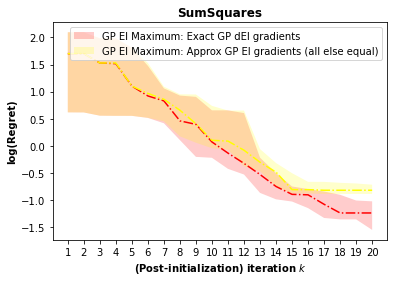

In [142]:
### Visualise!

title = func
plt.figure()

plt.plot(median_ExactSimpleRegret_exact, color = 'Red', ls='-.')
plt.plot(median_ApproxSimpleRegret_exact, color = 'Yellow', ls='-.')

xstar = np.arange(0, iters, step=1)
plt.fill_between(xstar, lower_ExactSimpleRegret_exact, upper_ExactSimpleRegret_exact, facecolor = 'Red', alpha=0.2, label='GP EI Maximum: Exact GP dEI gradients')
plt.fill_between(xstar, lower_ApproxSimpleRegret_exact, upper_ApproxSimpleRegret_exact, facecolor = 'Yellow', alpha=0.2, label='GP EI Maximum: Approx GP EI gradients (all else equal)')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show() #visualize!